In [1]:
%matplotlib inline
# from __future__ import division, print_function
from IPython.display import display


import os
os.environ["MKL_NUM_THREADS"] = "32" 
os.environ["NUMEXPR_NUM_THREADS"] = "32" 
os.environ["OMP_NUM_THREADS"] = "32" 

import numpy as np
import pandas as pd
import h5py
import re
import sys
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
import operator
import copy
import pickle


import community
from random import sample
import networkx as nx
from backspinpy import CEF_obj

# Tomography
import tomography
from tomography.utils import pad_to_cube, pad_to_square, shift_simmetrize
# from brainmap import *
from tomography.core import build_Design_Matrix
from tomography import get_x, get_plate, colorize, normalize_AUC

# Sklearn, scipy
import umap

from skimage.exposure import rescale_intensity
import scipy.ndimage as sc
import scipy.sparse
from scipy.integrate import simps
from sklearn.metrics.pairwise import euclidean_distances
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance_matrix
from skimage.segmentation import find_boundaries
from scipy import stats

from skimage.filters import gaussian
from skimage import exposure
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors
from skimage import morphology

from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, AgglomerativeClustering, ward_tree
from scipy.cluster.hierarchy import ward, dendrogram, linkage, to_tree, dendrogram, fcluster
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from skimage.measure import find_contours
from skimage.morphology import convex_hull_image



from sklearn.decomposition import FactorAnalysis, NMF, non_negative_factorization, PCA

# from helpers import *
sys.path.insert(0, os.path.abspath('../'))
# from data_loaders import *

np.random.seed(11)

import re

/home/ncpsb/anaconda3/envs/tomographer-env/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
# The following functions are required to create data for simulations. 
# The function create_filename_data will use the data and section it as would be done
# for creating strips of tissue (the secondary slices)

def get_angle(angle_list):
    """angle_list: list containing designated angles at positions 5:
    anglexxx
    for example: ['angle89', 'angle100']"""
    new_array = np.empty(0)
    array = [np.append(new_array, int(x[5:])) for x in angle_list]
    return np.array(array).flatten()


def random_2_points(dist, accu=10, xc= 100, yc=100):
    ang_dir = np.random.uniform(0, 2*np.pi)
    deltay = accu * np.sin(ang_dir)
    deltax = accu * np.cos(ang_dir)
    mu1 = np.array([xc + deltax, yc + deltay ])

    ang_dir = np.random.uniform(0, 2*np.pi)
    deltay = dist * np.sin(ang_dir)
    deltax = dist * np.cos(ang_dir)
    mu2 = mu1 + np.array([deltax, deltay])
    return mu1, mu2


def generate_gaussians(mu1, mu2, sigma1, sigma2, level_express=1, shape=(200,200)):
    X,Y = np.meshgrid(range(shape[0]), range(shape[1]))
    pos = np.column_stack([X.flat[:], Y.flat[:]])
    density = multivariate_normal.pdf(pos, mean=mu1, cov=sigma1) + multivariate_normal.pdf(pos, mean=mu2, cov=sigma2)
    average_expression = level_express * density / np.max(density)
    return (average_expression).reshape(shape)

def create_filename_data(file_path, angles_names, angles_values, var, factor, mask, width, error=True):
    """Creates h5py file with data. Noise is added automatically unless argument error=False
    
    Args:
    
    file_path: string path to .h5py
    angles_names: list of angle names in format anglexxx
    angles_values: integer values of angle names
    var: dictionary containing gene_list and attributes
    factor: amount of noise (poisson) to add
    error: if True, adds error, else data is taken as given"""
    
    if os.path.isfile(file_path):
        !rm $file_path
    
    fout = h5py.File(file_path, 'w')
    D, proj_len = tomography.core.build_Design_Matrix(angles_values,
                                                  [width,]*len(angles_names),
                                                  mask,
                                                  0.1,
                                                  notation_inverse=True,
                                                  return_projlen=True)
    profiles = []
    for g_name, g_ in var.items():
        b_ = D.dot((g_.data*mask).flat[:])
        cum_proj_len = np.hstack([[0], proj_len]).cumsum()
        for i, name in enumerate(angles_names):
            if error:
                tmp = np.random.poisson(b_[cum_proj_len[i]:cum_proj_len[i+1]] / 
                                        np.mean(b_[cum_proj_len[i]:cum_proj_len[i+1]]) * factor, size=None)
                
                
            else:
                tmp = b_[cum_proj_len[i]:cum_proj_len[i+1]]
            fout.create_dataset("genes/%s/%s" % (g_name, name), data=tmp)
            profiles.append(tmp)
    for i, name in enumerate(angles_names):
        fout.create_dataset("coordinates/%s" % name, data=np.arange(proj_len[i]))
    
    fout.close()
    return profiles

In [3]:
from __future__ import division, print_function

from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d
from scipy.signal import correlate
from IPython.display import display
import tomography
from tomography.core import build_Design_Matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from backspinpy import CEF_obj
from sklearn.svm import SVR
from scipy import stats
import scipy.sparse
import pickle
from scipy.integrate import simps
from skimage.measure import find_contours
from skimage import morphology
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit
from tomography import get_x, get_plate, colorize, normalize_AUC

import h5py

def autocorr_shift(source, target, shift_lim=None):
    if shift_lim is None:
        return np.argmax(correlate(target, source)) - (len(source)-1)
    else:
        autoR = correlate(target, source)
        indexes = np.argsort(autoR)[::-1] - (len(source)-1)
        for i in indexes:
            if i >= shift_lim[0] and i <= shift_lim[1]:
                return i

def equilibrate(a, b):
    le = max(len(a), len(b))
    tempa, tempb = np.zeros((le,)), np.zeros((le,)) 
    tempa[:len(a)] = a
    tempb[:len(b)] = b
    return tempa, tempb

def interpolate(xi, p):
    full_x = np.arange(xi[0], xi[-1] + 1)
    linear_interpolator = interp1d(xi, p, kind='linear', fill_value=0, bounds_error=False)
    return full_x, linear_interpolator(full_x)

def gauss_kernel(x, mu=0, sigma=1):
    return np.exp(- 0.5 * (x - mu)**2 / sigma**2)
    #return scipy.stats.norm.pdf(x, loc=mu, scale=sigma)

def bilateral_filter(y, sigma_s=2.5, sigma_r_fold=2.5):
    x = np.arange(len(y))
    fr = gauss_kernel(y, mu=y[:,None], sigma=sigma_r_fold * np.mean(np.abs(np.diff(y[y>0]))))
    gs = gauss_kernel(x, mu=x[:,None], sigma=sigma_s)
    return (y[:,None] * fr * gs).sum(0) / (fr * gs).sum(0)

def bilateral_kernel_show(y, sigma_s=2.5, sigma_r_fold=2.5):
    x = np.arange(len(y))
    fr = gauss_kernel(y, mu=y[:,None], sigma=sigma_r_fold * np.mean(np.abs(np.diff(y[y>0]))))
    gs = gauss_kernel(x, mu=x[:,None], sigma=sigma_s)
    plt.imshow(fr*gs, interpolation="bilinear")

def score_prediction(y, y_pred, shift_lim=None):
    # DATA
    y = np.pad(y, (6,6), mode="constant")
    y = bilateral_filter(y)
    y = y / np.mean(y[y>np.percentile(y[y>0], 80)])

    # PREDICTED
    y_pred = np.pad(y_pred, (6,6), mode="constant")
    y_pred = bilateral_filter(y_pred)
    y_pred = y_pred / np.mean(y_pred[y_pred>np.percentile(y_pred[y_pred>0], 80)])

    # DETERMINE SHIFT
    x_shift = autocorr_shift(y, y_pred, shift_lim=shift_lim)
    
    # APPLY SHIFT
    if x_shift < 0:
        if len(y_pred) < len(y):
            y = y[-x_shift:-x_shift+len(y_pred)]
            y_pred = y_pred[:len(y)]
        elif len(y_pred) >= len(y):
            y = y[-x_shift:]
            y_pred = y_pred[:len(y)]
    elif x_shift >= 0:
        if len(y_pred) < len(y):
            y = np.pad(y, (x_shift, 0), mode="constant")[:len(y_pred)]
            y_pred = y_pred
        elif len(y_pred) >= len(y):
            y = np.pad(y, (x_shift, 0), mode="constant")[:len(y_pred)]
            y_pred = y_pred[:len(y)]

    # CALCULATE SCORES
    corr_score = 1-np.corrcoef(y[~((y==0) & (y_pred==0))], y_pred[~((y==0) & (y_pred==0))])[0,1]
    L2_score = np.sum((y - y_pred)**2)
    return corr_score, L2_score, y, y_pred, x_shift

def grid_score_prediction(angles_probes, wid_probes, D_cache, ref_im_flat, y, pw, return_ys=False):
    record = {"corr_score": np.zeros((len(angles_probes), len(wid_probes))),
              "L2_score": np.zeros((len(angles_probes), len(wid_probes))),
              "y": [[] for i in range(len(angles_probes))],
              "y_pred": [[] for i in range(len(angles_probes))],
              "x_shift": np.zeros((len(angles_probes), len(wid_probes)))}
    for i, angle in enumerate(angles_probes):
        for j, wid in enumerate(wid_probes):
            predicted_angle = angle
            predicted_wid = wid
            y_pred = D_cache[(predicted_angle, predicted_wid)] @ ref_im_flat

            corr_score, L2_score, y_hat, y_pred_hat, x_shift = score_prediction(y, y_pred,
                                                                                shift_lim=pw)
            record["corr_score"][i, j] = corr_score
            record["L2_score"][i, j]  = L2_score
            if return_ys:
                record["y"][i].append(y_hat)
                record["y_pred"][i].append(y_pred_hat)
            record["x_shift"][i, j]  = x_shift
    return record

class DCache(object):
    def __init__(self, mask):
        self.D = {}
        self.mask = mask
        
    def __getitem__(self, key):
        try:
            return self.D[key]
        except KeyError:
            rad, wid = np.deg2rad(key[0]), key[1]
            self.D[key] = build_Design_Matrix(np.array([rad]), [wid], 1. * self.mask, return_sparse=True)[0]
            return self.D[key]

In [4]:
raw_data = pd.read_excel("./SP/rawdata.xlsx")
raw_data = raw_data.loc[~raw_data["PG.Genes"].isna(),:]

Meta = raw_data.iloc[:,:7]
Expression = raw_data.iloc[:,7:]

sample_id = [re.findall(" ([A-Z]+\d+)", x)[0] for x in Expression.columns]
Expression.columns = sample_id
sample_id.sort()
sample_id = [i for i in  sample_id if "QC" not in i]

Expression.index = [ i.split(";")[0] if ";" in str(i) else i for i in Meta["PG.Genes"] ]
Expression = Expression.loc[:,sample_id]

Expression = Expression.loc[~Expression.index.duplicated(),:]
##### IRT ######
IRT = pd.read_excel("./SP/iRT_unnormalized.xlsx")

IRT_Meta = IRT.iloc[:,:2]
IRT_Expression = IRT.iloc[:,2:]
IRT_Expression = IRT_Expression.iloc[:,[True if "PEP.Quantity" in i else False for i in IRT_Expression.columns ]]

sample_id = [re.findall(" ([A-Z]+\d+)", x)[0] for x in IRT_Expression.columns if "PEP.Quantity" in x]
IRT_Expression.columns = sample_id
sample_id.sort()
sample_id = [i for i in  sample_id if "QC" not in i]

IRT_Expression.index = IRT_Meta["Name"]
IRT_Expression = IRT_Expression.loc[:,sample_id]

In [5]:

for i in ["A","B","C","D","E","F","G","H"]:
    Exp = IRT_Expression.loc[:,[i in j for j in IRT_Expression.columns]]
    Exp.insert(0,i+"_tmp1",0)
    Exp.insert(0,i+"_tmp2",0)
    Exp.insert(Exp.shape[1],i+"_tmp3",0)
    Exp.insert(Exp.shape[1],i+"_tmp4",0)
    Exp.columns = [i+ str(k+1) if len(str(k+1))==2 else i+"0"+ str(k+1) for k in range(len(Exp.columns)) ]
    if i == "A":
        ref_IRT = Exp
    else:
        ref_IRT = pd.concat([ref_IRT,Exp],axis=1)
        
for i in ["A","B","C","D","E","F","G","H"]:
    Exp = Expression.loc[:,[i in j for j in Expression.columns]]
    Exp.insert(0,i+"_tmp1",0)
    Exp.insert(0,i+"_tmp2",0)
    Exp.insert(Exp.shape[1],i+"_tmp3",0)
    Exp.insert(Exp.shape[1],i+"_tmp4",0)
    Exp.columns = [i+ str(k+1) if len(str(k+1))==2 else i+"0"+ str(k+1) for k in range(len(Exp.columns)) ]
    if i == "A":
        ref = Exp
    else:
        ref = pd.concat([ref,Exp],axis=1)

In [6]:
Expression = ref.copy()
IRT_Expression = ref_IRT.copy()


Expression.columns = Expression.columns + "_1_W"
IRT_Expression.columns = IRT_Expression.columns + "_1_W"

# 先插补为0，去观察离群值
IRT_Expression2 = IRT_Expression.fillna(0,inplace=False)
Expression2 = Expression.fillna(0,inplace=False)

angles_name, angles_ix = np.unique( [re.findall("^[A-Z]",i)[0] for i in Expression.columns], return_inverse=True )

data = {}
spikes = {}
for ix, angle in enumerate(angles_name):
    data[angle] = Expression2.loc[:,angles_ix==ix].astype(float)
    spikes[angle] = IRT_Expression2.loc[:,angles_ix==ix].astype(float)
    
for name_angle, df in data.items():
    df.columns = df.columns + ["_x"+str(i) for i in range(df.shape[1])]
# do the same to the spikes
for name_angle, df in spikes.items():
    df.columns = df.columns + ["_x"+str(i) for i in range(df.shape[1])]

In [7]:
# IRT_Expression2.loc[:,["A13_1_W","A14_1_W","B23_1_W","B24_1_W","C03_1_W","C04_1_W","C22_1_W","C23_1_W","E06_1_W","E07_1_W","H18_1_W","H19_1_W"]]

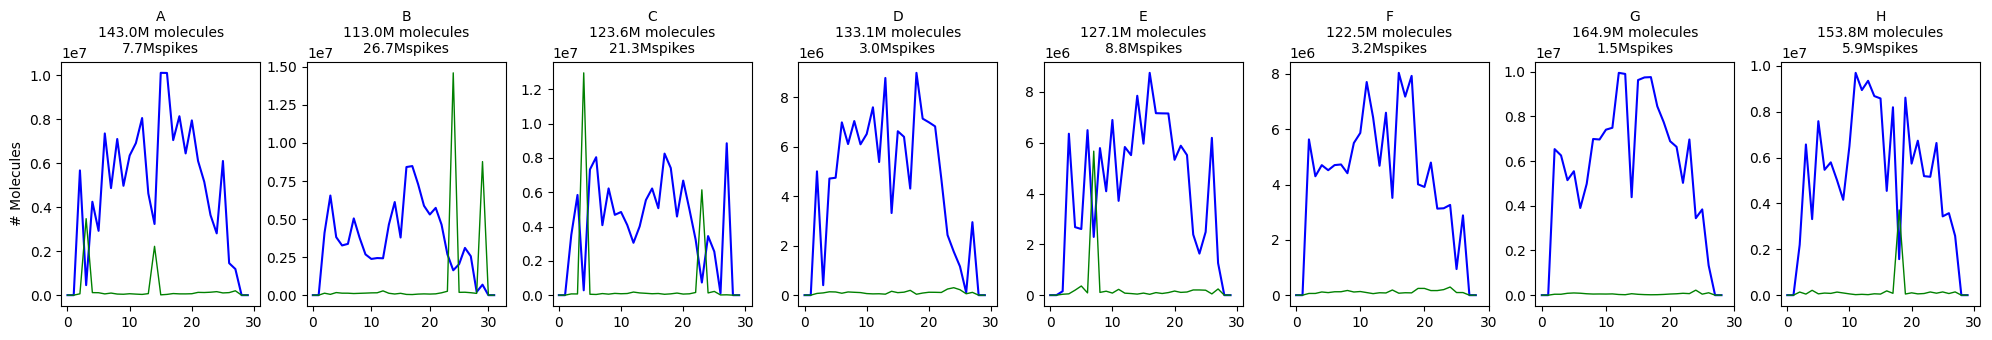

In [8]:
plt.figure(figsize=(20,3.5))
tomography.plot_raw_data_sum(data, spikes)
plt.savefig('./Overlap/1.pdf')

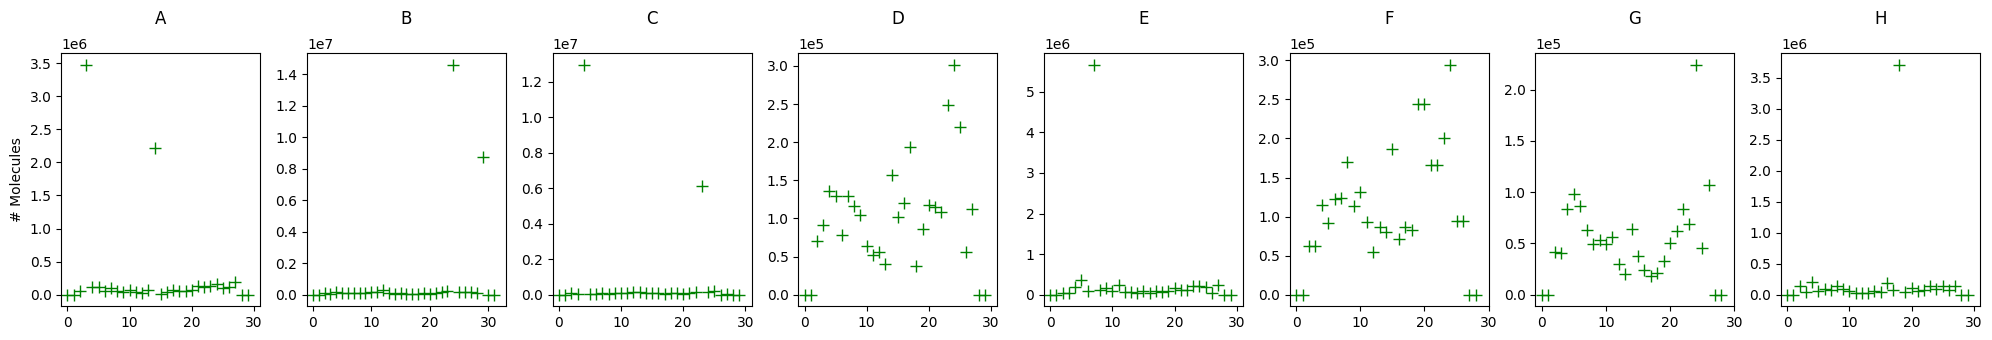

In [9]:
plt.figure(figsize=(20,3.5))
tomography.plot_raw_spikes(spikes)
plt.savefig('./Overlap/2.pdf')

In [10]:
# Expression2 = Expression2.loc[:,[x not in ["A02_1_W","A13_1_W","B23_1_W","B27_1_W","B28_1_W","C03_1_W","C22_1_W","E06_1_W","H18_1_W"] for x in Expression2.columns]]
# IRT_Expression2 = IRT_Expression2.loc[:,[x not in ["A02_1_W","A13_1_W","B23_1_W","B27_1_W","B28_1_W","C03_1_W","C22_1_W","E06_1_W","H18_1_W"] for x in IRT_Expression2.columns]]

In [11]:
# Expression2 = Expression2.loc[:,[x not in ["A03_1_W","A14_1_W","B24_1_W","B28_1_W","B29_1_W","C04_1_W","C23_1_W","E07_1_W","H18_1_W"] for x in Expression2.columns]]
# IRT_Expression2 = IRT_Expression2.loc[:,[x not in ["A03_1_W","A14_1_W","B24_1_W","B28_1_W","B29_1_W","C04_1_W","C23_1_W","E07_1_W","H18_1_W"] for x in IRT_Expression2.columns]]

In [12]:
Expression2 = Expression2.loc[:,[x not in ["A04_1_W","A15_1_W","B25_1_W","B29_1_W","B30_1_W","C05_1_W","C24_1_W","E08_1_W","H19_1_W"] for x in Expression2.columns]]
IRT_Expression2 = IRT_Expression2.loc[:,[x not in ["A04_1_W","A15_1_W","B25_1_W","B29_1_W","B30_1_W","C05_1_W","C24_1_W","E08_1_W","H19_1_W"] for x in IRT_Expression2.columns]]

In [13]:
angles_name, angles_ix = np.unique( [re.findall("^[A-Z]",i)[0] for i in Expression2.columns], return_inverse=True )

data = {}
spikes = {}
for ix, angle in enumerate(angles_name):
    data[angle] = Expression2.loc[:,angles_ix==ix].astype(float)
    spikes[angle] = IRT_Expression2.loc[:,angles_ix==ix].astype(float)
    
for name_angle, df in data.items():
    df.columns = df.columns + ["_x"+str(i) for i in range(df.shape[1])]
# do the same to the spikes
for name_angle, df in spikes.items():
    df.columns = df.columns + ["_x"+str(i) for i in range(df.shape[1])]

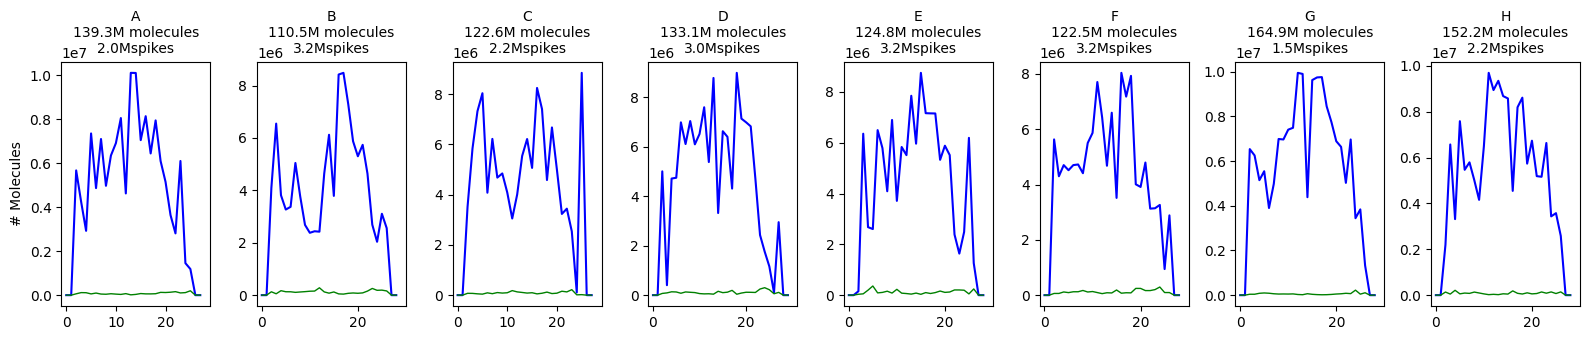

In [14]:
plt.figure(figsize=(16,3.5))
tomography.plot_raw_data_sum(data, spikes,)

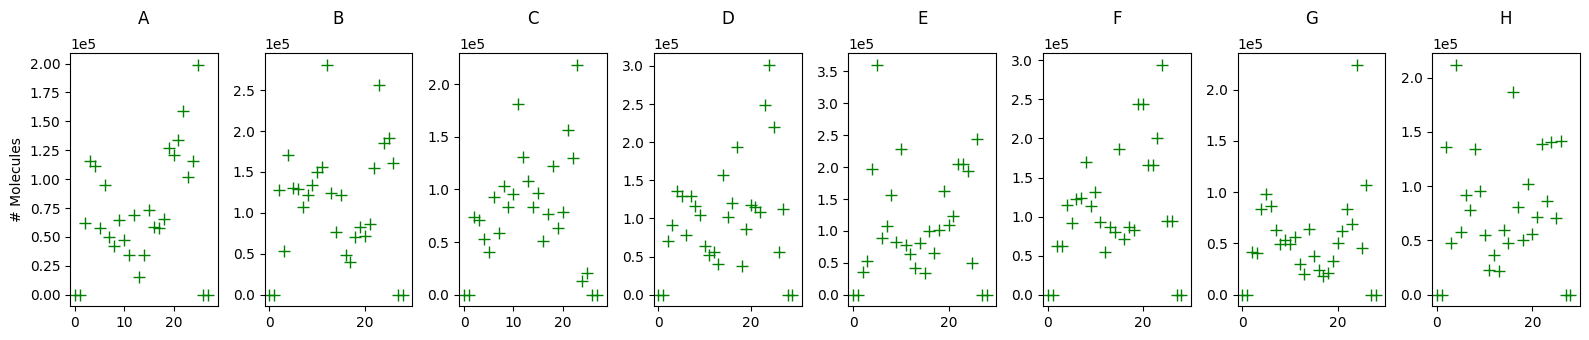

In [15]:
plt.figure(figsize=(16,3.5))
tomography.plot_raw_spikes(spikes)

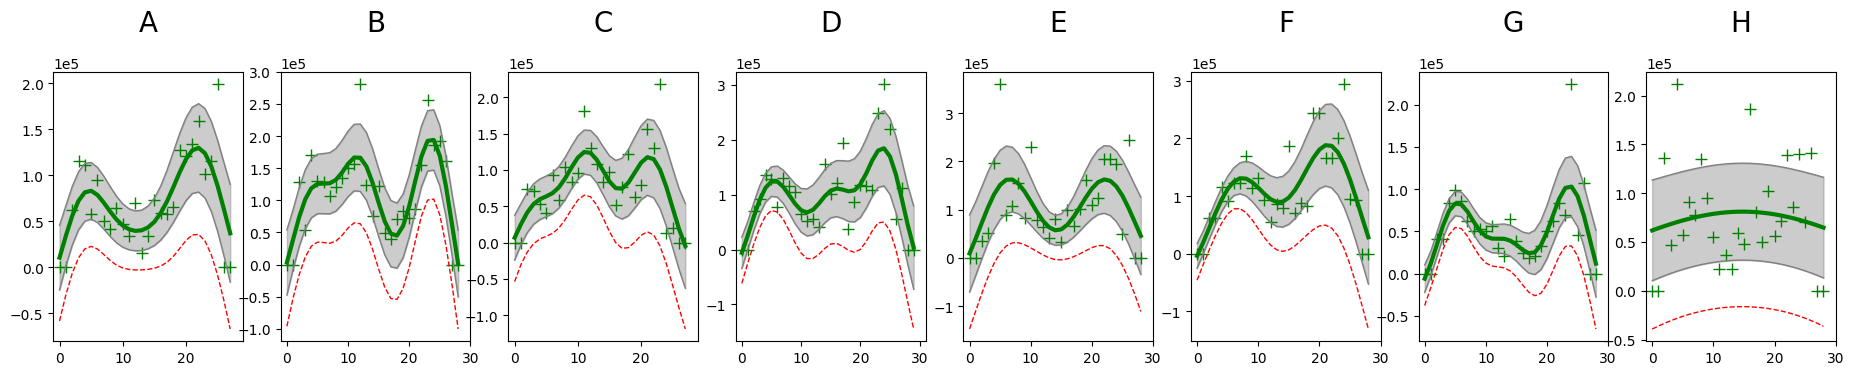

In [16]:
plt.figure(figsize=(23,3.5))
np.random.seed(15071990)
flag_low_spikes = {}
for i, (name_angle, spikes_df) in enumerate(spikes.items()):
    # Prepare model fit
    x = np.arange(0,spikes_df.shape[1], dtype=float)
    y = spikes_df.sum(0).values
    
    # Fit Etheroscedastic model
    y_new, y_std = tomography.predict_gp_heteroscedastic(y, x[:,None], x[:,None], verbose=False)
    
    # Flag samples that had too low spikes
    flag = y < y_new - 1.96*y_std
    flag_low_spikes[name_angle] = flag
    
    # Plot
    plt.subplot(181+i)
    plt.title("%s\n" % (name_angle), fontsize=20)
    tomography.plot_gp_with_std(x, y, y_new, y_std, flag)
    
plt.savefig('./Overlap/3.pdf')
    

#基于spikes的结果，去除个别离群点(如果在蛋白质组数据中，也可以尝试将总的做一下类似的分析，然后去除离群样本)
# 这结果实际上还没有去除两个palate的差异，此时计算的离群点可能不一定离群

# Remove low spikes
for name_angle in data.keys():
    data[name_angle] = data[name_angle].loc[:, ~(flag_low_spikes[name_angle])]
    spikes[name_angle] = spikes[name_angle].loc[:, ~(flag_low_spikes[name_angle])]

In [17]:
# # 利用spikes来矫正数据不同palate的数据
# # 具体的矫正原理就是：
# # 将每个角度的数据分别计算，然后同一个角度存在两个不同的palate，这两个palate的spikes的均值作为矫正的目标。
# # 实际上在计算均值之前，这里还将两个palate的数据分别进行拟合，获得每个样本预测值(可以认为这里排除了潜在的噪声，跟之前去除离群值不一样的是，这里是分开拟合的)
# # 有了每个条的预测值以后就能计算该角度的均值
# # 以此为目标，计算每个条要从预测值转变为目标值的系数
# # 将这系数分别乘以表达矩阵(对应的角度和条位置)

# # Calculate adjustment parameters
# coordinates_dict, adjustments = tomography.use_gp_to_adjust_spikes_diff(spikes, q=0.3)

# plt.figure(figsize=(17,5.5))
# tomography.plot_spikes_adjustment(coordinates_dict)


# # perform normalization
# data_norm = {}
# for name_angle in data.keys():
#     data_norm[name_angle] = data[name_angle].copy()
    
# for name_angle in data_norm.keys():
#     data_norm[name_angle] *= adjustments[name_angle]

In [18]:
data_norm = {}
for name_angle in data.keys():
    data_norm[name_angle] = data[name_angle].copy()
#     data_norm[name_angle] = data_norm[name_angle]/data_norm[name_angle].mean(0)
#     data_norm[name_angle] = 1e5*data_norm[name_angle]/data[name_angle].sum().sum()
    data_norm[name_angle] = data_norm[name_angle]/data_norm[name_angle].apply(lambda x:x[x!=0].median())
    data_norm[name_angle] = data_norm[name_angle].fillna(0)

In [19]:
# data_norm = {}
# for name_angle in data.keys():
#     data_norm[name_angle] = data[name_angle].copy()
# #     data_norm[name_angle] = data_norm[name_angle]/data_norm[name_angle].mean(0)
#     data_norm[name_angle] = 1e5*data_norm[name_angle]/data[name_angle].sum().sum()

In [20]:
# AUC normalize(类似于去除测序深度)
# data_norm = data.copy()
# data_norm = normalize_AUC(data_norm)

In [21]:
# data_norm = data.copy()

(9296, 28)


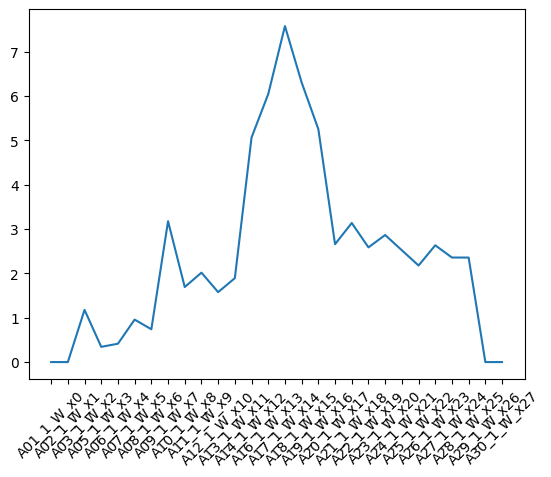

(9296, 29)


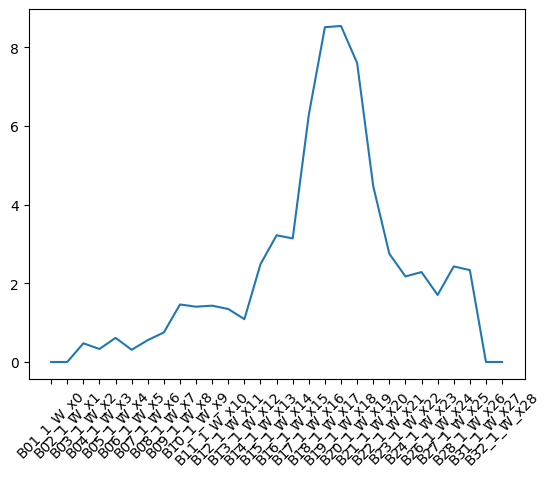

(9296, 28)


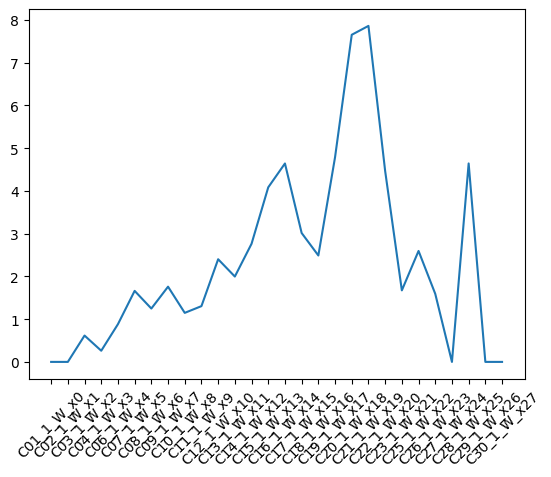

(9296, 30)


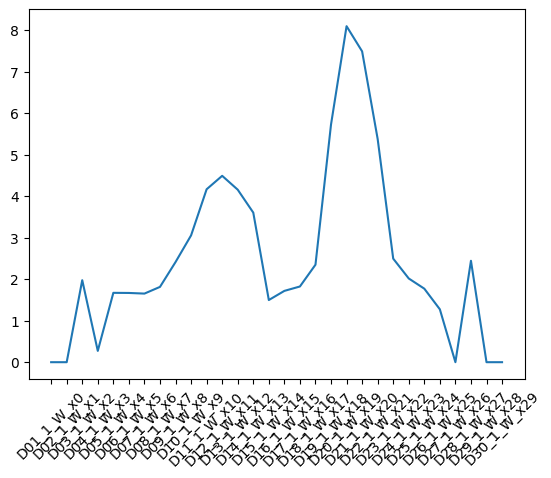

(9296, 29)


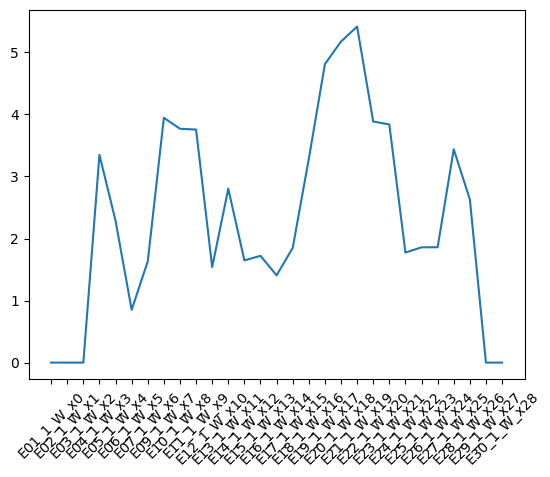

(9296, 29)


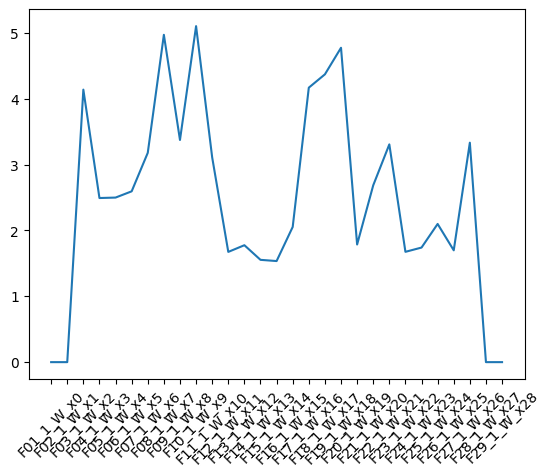

(9296, 29)


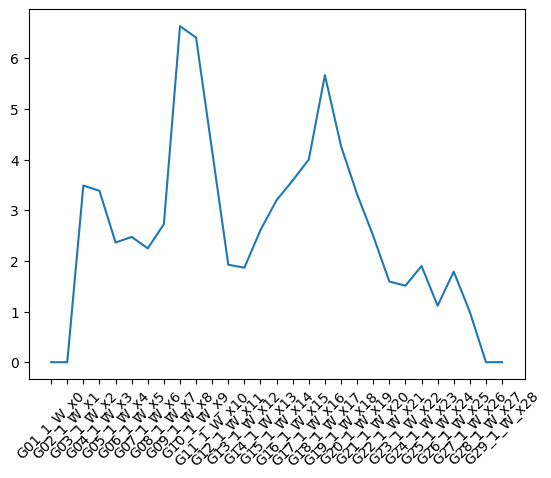

(9296, 29)


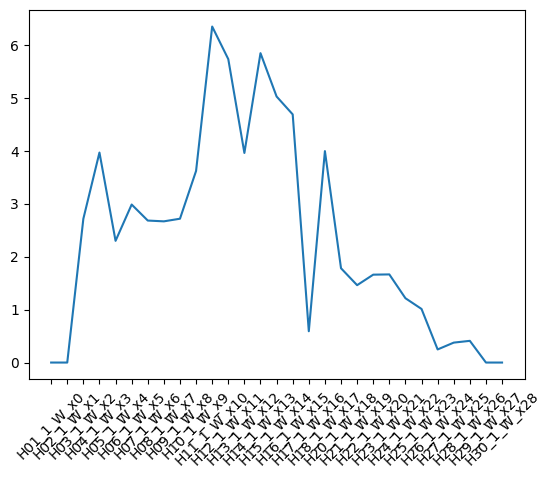

231


In [22]:
total = 0
for i in data_norm.keys():
    plt.plot(data_norm[i].loc["Cacng8",:])
    print(data_norm[i].shape)
    total += data_norm[i].shape[1]
    plt.xticks(rotation=45)
    plt.show()
    
print(total)

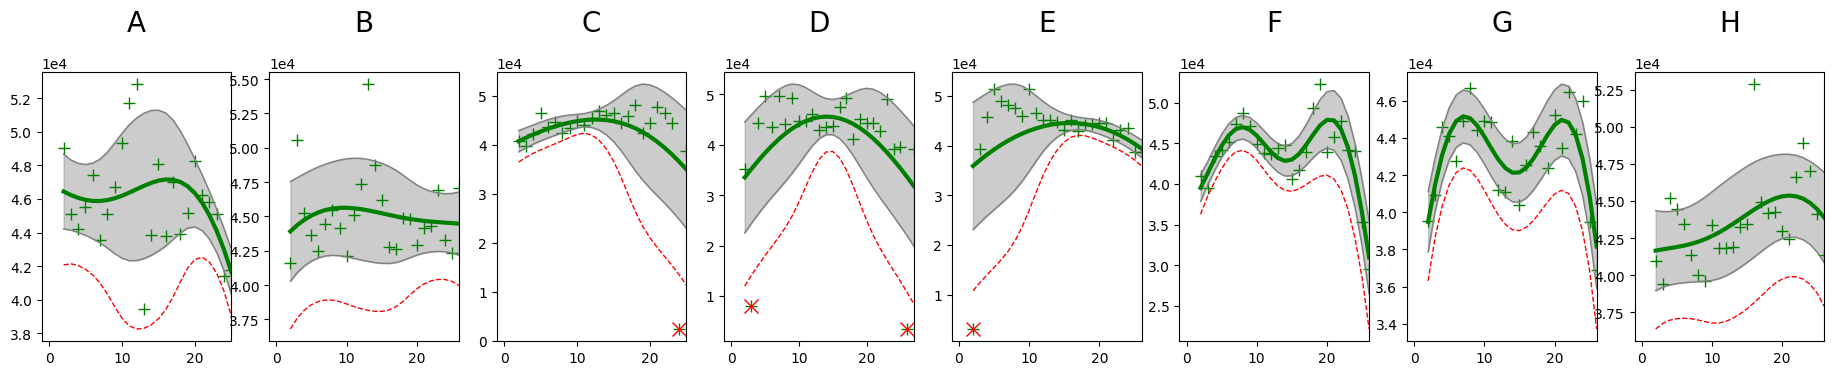

In [23]:
plt.figure(figsize=(23,3.5))
np.random.seed(15071990)
flag_low_sample = {}
for i, (name_angle, df) in enumerate(data_norm.items()):
    # Prepare model fit
    x = get_x(df)[2:-2]
    y = df.sum(0).values[2:-2]
    
    # Fit Etheroscedastic model
    y_new, y_std = tomography.predict_gp_heteroscedastic(y, x[:,None], x[:,None], verbose=False)
    
    # Flag samples that had too low spikes
    flag = y < y_new - 1.96*y_std
    flag_low_sample[name_angle] = flag
    
    # Plot
    plt.subplot(181+i)
    plt.title("%s\n" % (name_angle), fontsize=20)
    tomography.plot_gp_with_std(x, y, y_new, y_std, flag_low_sample[name_angle])
    flag_low_sample[name_angle] = np.concatenate(([False, False], flag, [False, False]))

plt.savefig('./Overlap/4.pdf')
# remove flagged data points
for name_angle in data_norm.keys():
    data_norm[name_angle] = data_norm[name_angle].loc[:,~(flag_low_sample[name_angle]) ]

In [24]:
# from sklearn.cluster import KMeans
# from umap import UMAP

# Expression3 = 1e5*Expression2/Expression2.sum(0)

(9296, 28)


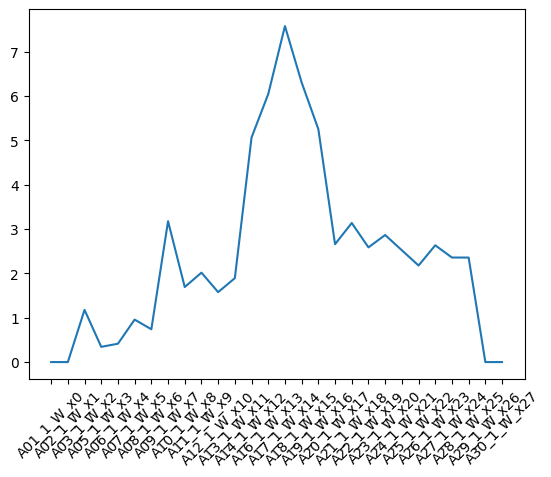

(9296, 29)


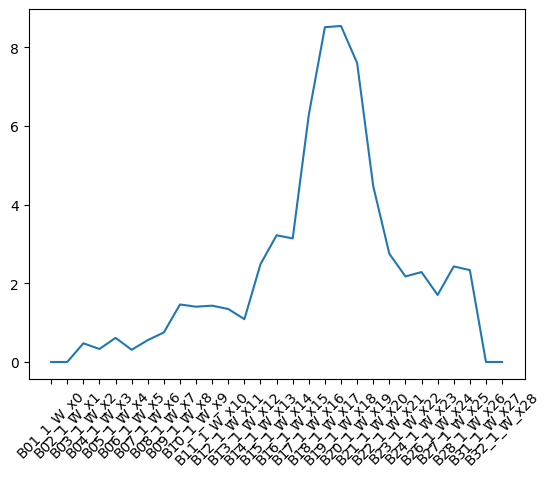

(9296, 27)


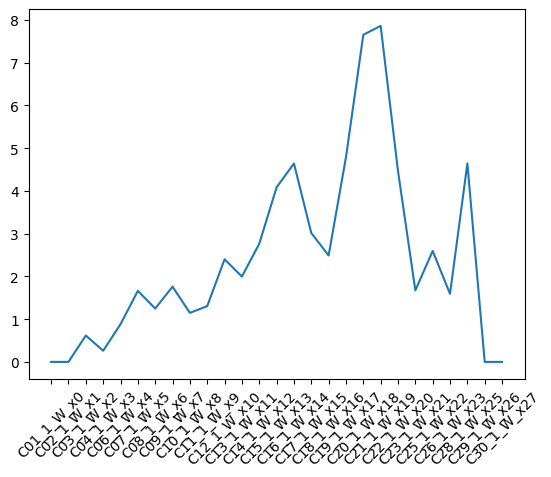

(9296, 28)


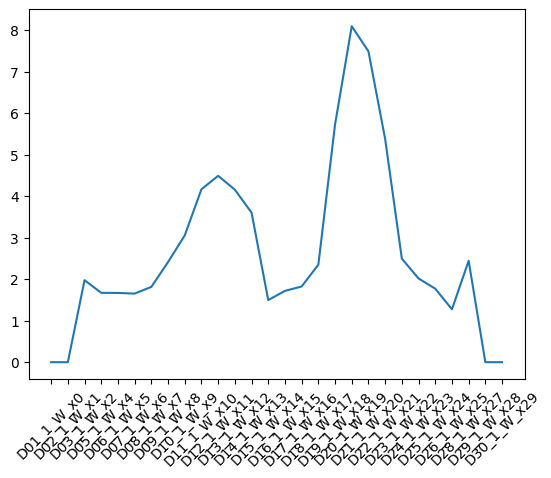

(9296, 28)


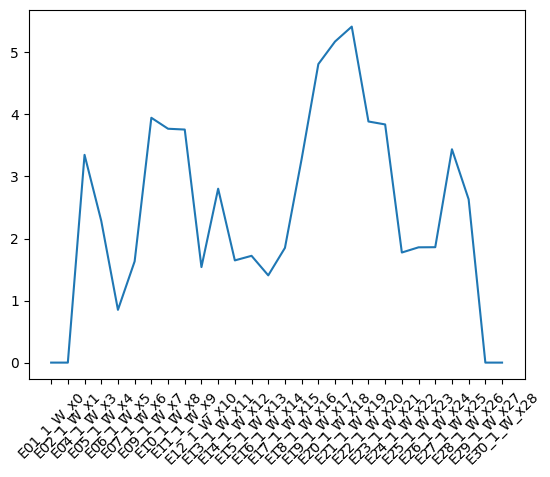

(9296, 29)


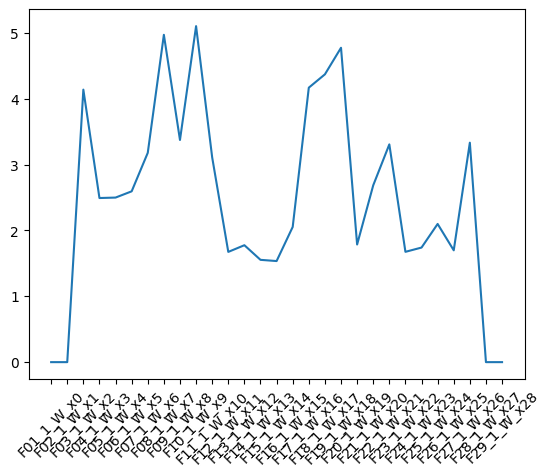

(9296, 29)


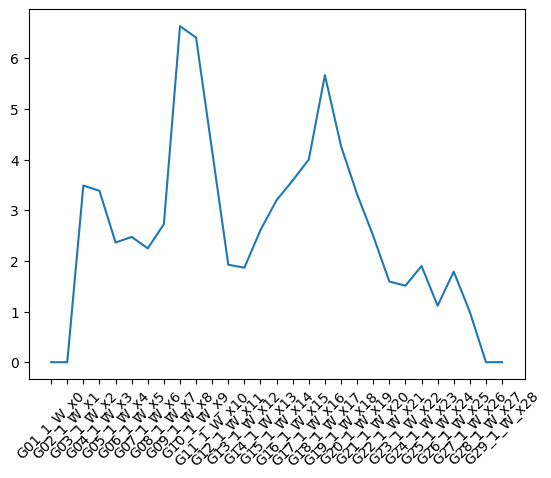

(9296, 29)


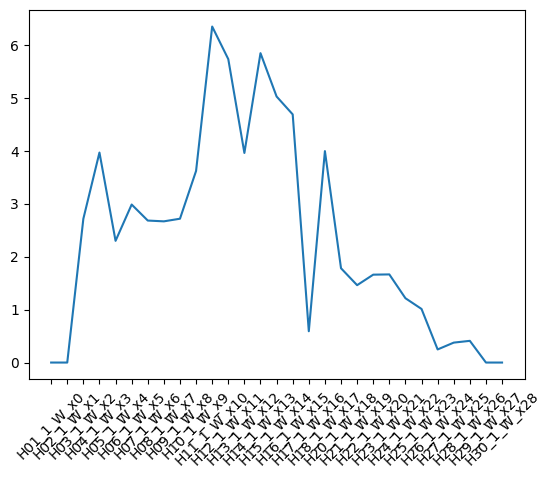

227


In [25]:
total = 0
for i in data_norm.keys():
    plt.plot(data_norm[i].loc["Cacng8",:])
    print(data_norm[i].shape)
    total += data_norm[i].shape[1]
    plt.xticks(rotation=45)
    plt.show()
    
print(total)

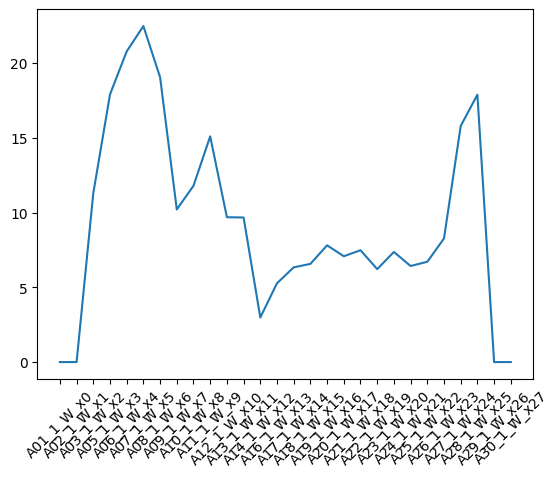

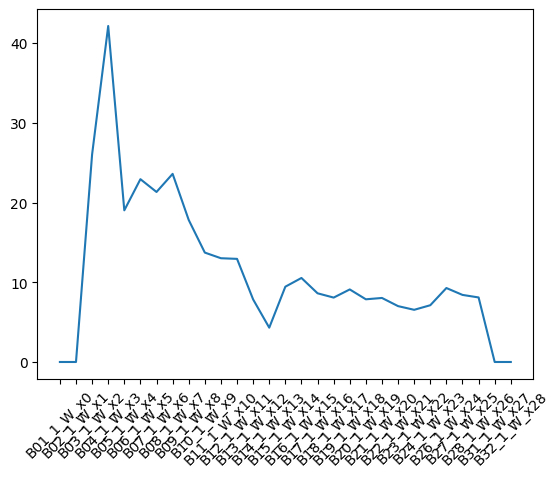

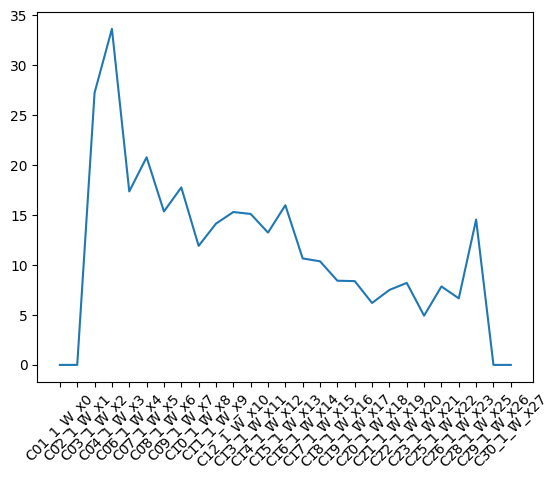

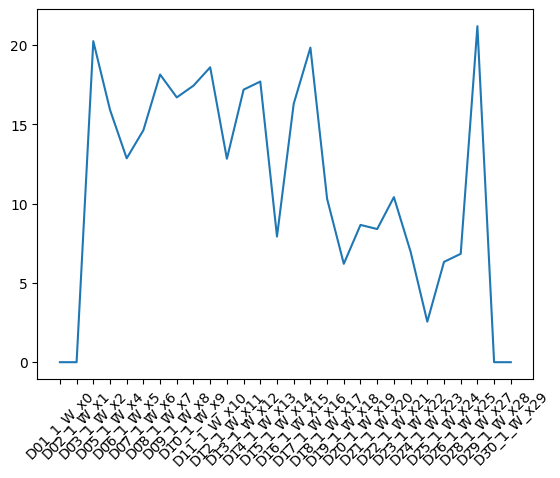

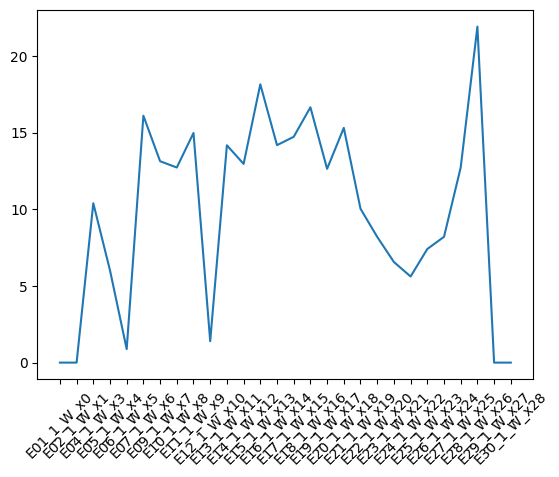

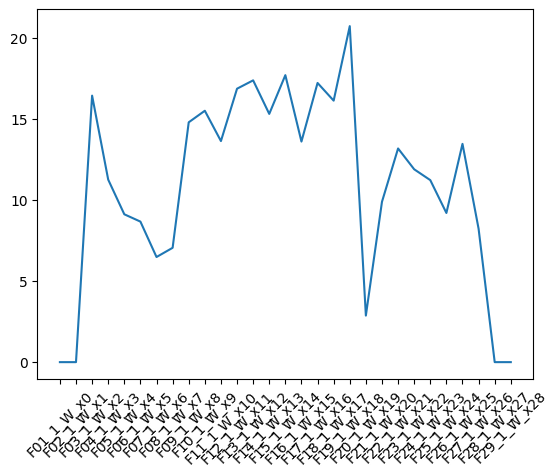

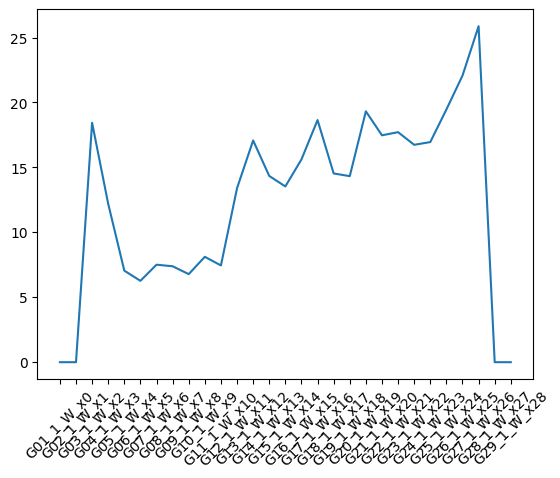

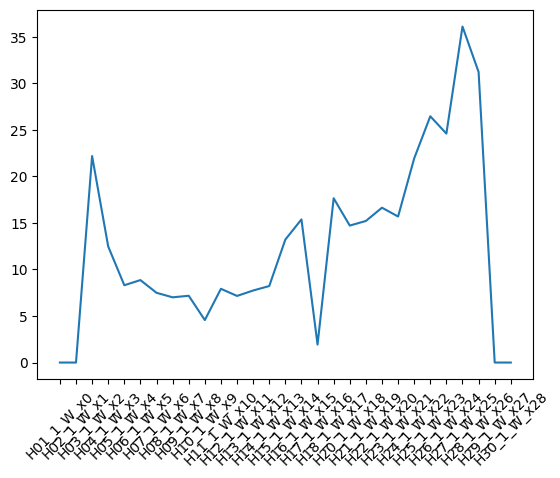

In [26]:
for i in data_norm.keys():
    plt.plot(data_norm[i].loc["Aqp4",:])
    plt.xticks(rotation=45)
    plt.show()

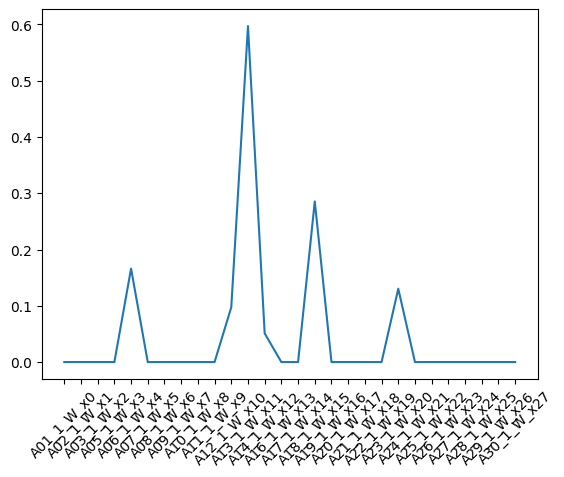

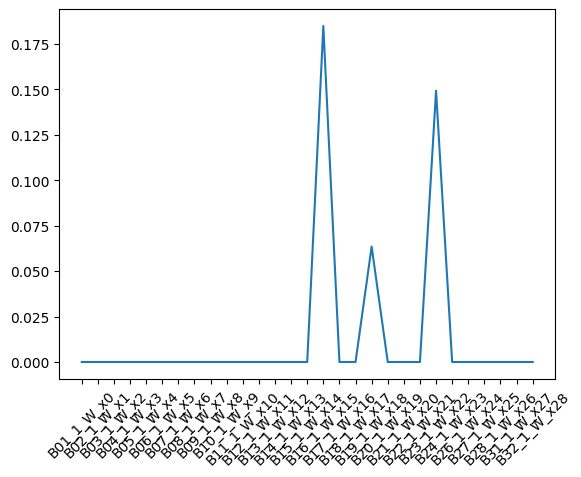

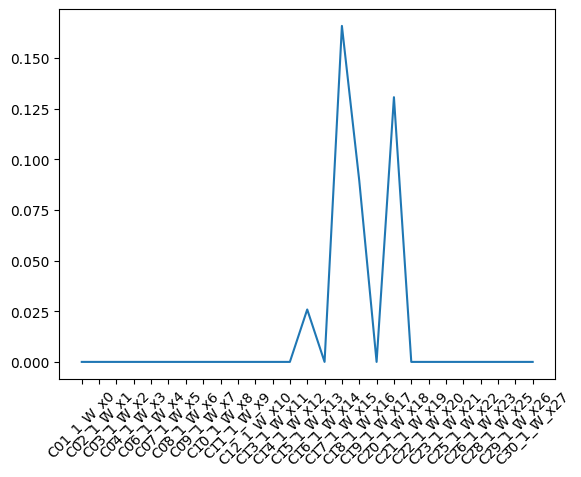

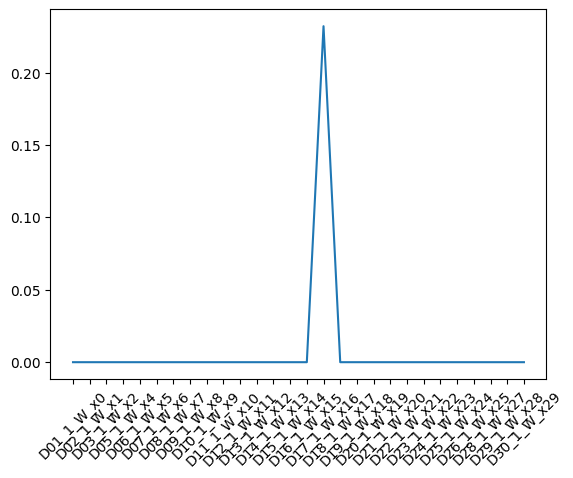

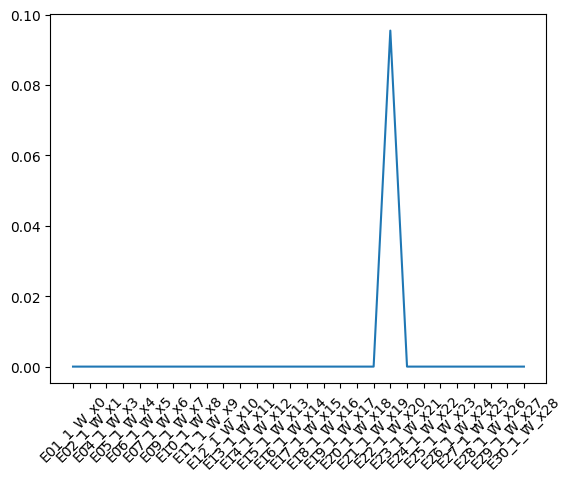

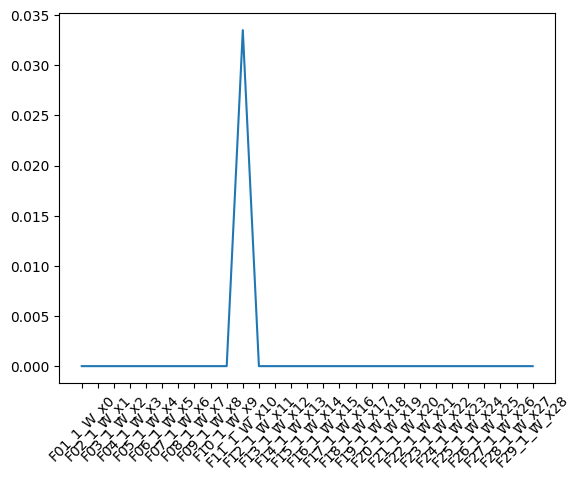

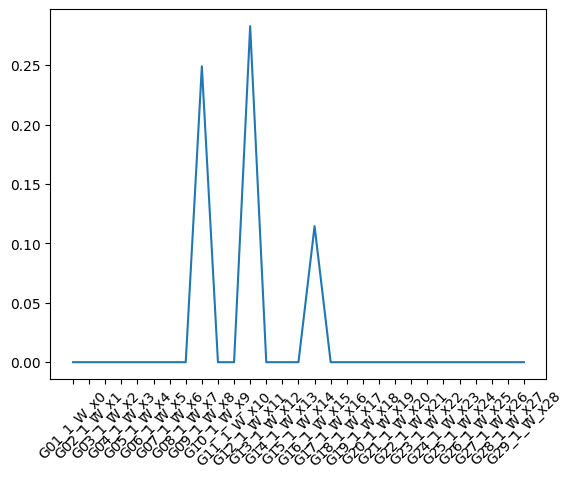

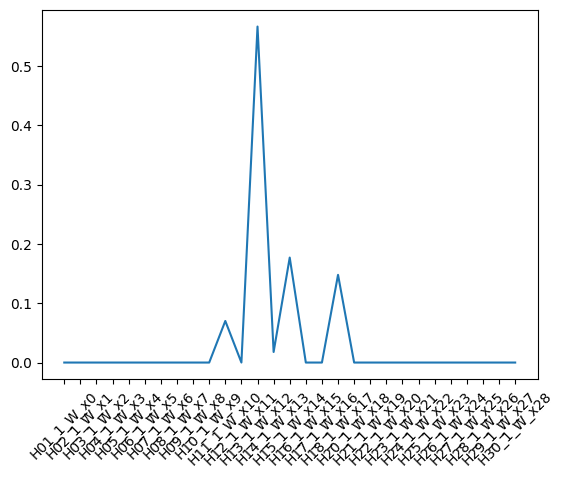

In [27]:
for i in data_norm.keys():
    plt.plot(data_norm[i].loc["Rgs9",:])
    plt.xticks(rotation=45)
    plt.show()

In [28]:
# # 观察不同角度间的基因表达的相关性，对角线展示了每个角度中所有基因的表达水平的直方图分布
# plt.figure(figsize=(10,10))
# gs = plt.GridSpec(8,8)
# for i, name_angle1 in enumerate(data_norm.keys()):
#     for j, name_angle2 in enumerate(data_norm.keys()):
#         if i < j:
#             ax = plt.subplot(gs[i,j]) 
#             ax.scatter(np.log2(data_norm[name_angle2].sum(1) + 1e-6),
#                        np.log2(data_norm[name_angle1].sum(1) + 1e-6),
#                        lw=0, s=8,alpha=0.3)
#             ax.plot(np.arange(20),np.arange(20), c="k")
#             plt.axis("equal")
#             plt.xlim(-0.5, 18)
#             plt.ylim(-0.5, 18)
#         if i == j:
#             ax = plt.subplot(gs[i,j]) 
#             v = np.log2(data_norm[name_angle1].sum(1))
#             ax.hist(v[np.isfinite(v)],bins=50,orientation="horizontal")
#             plt.xlabel(name_angle1)
#             plt.ylim(-0.5,18)
#             plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.tight_layout()

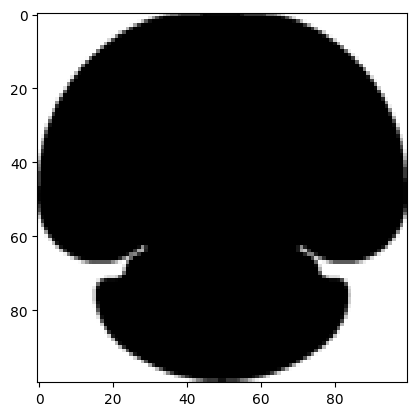

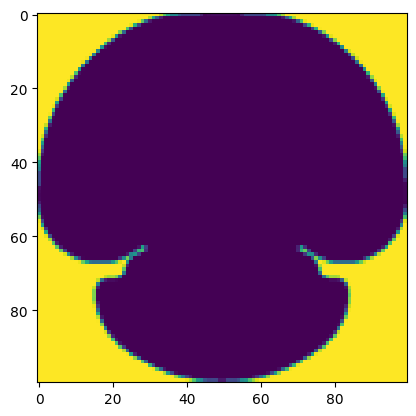

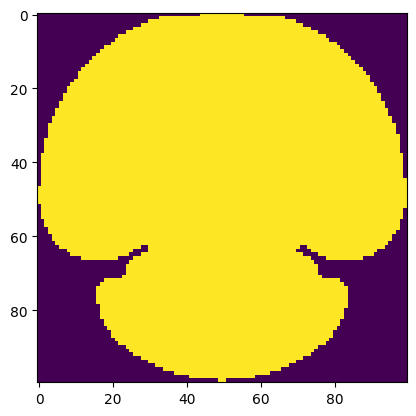

In [29]:
from PIL import Image

mask_img = np.array(Image.open("./SP/mask_new.png").convert("L").resize((100,100))).astype("float64")
# mask_img = mask_img.transpose()
plt.imshow(mask_img, interpolation="none",cmap="gray")
plt.show()

mask_img = mask_img/255
plt.imshow(mask_img/255)
plt.show()

mask_img = (mask_img <0.1).astype(float)

plt.imshow(mask_img)
plt.show()

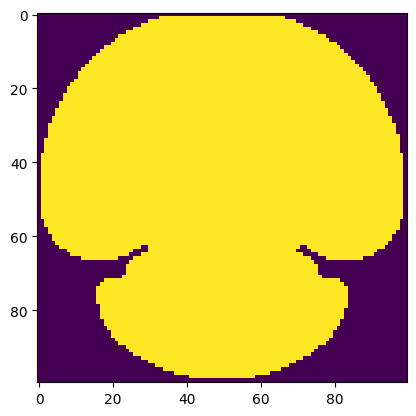

In [30]:
mask_img[:,-1:] = 0
mask_img[:,:1] = 0
mask_img[:1,:] = 0
mask_img[-1:,:] = 0
plt.imshow(mask_img)
plt.show()

In [31]:
# mask_img = np.array(Image.open("./SP/mask3.png").convert("L")).astype("float64")
# def generate_mask(img_height,img_width,radius,center_x,center_y):
 
#     y,x=np.ogrid[0:img_height,0:img_width]
 
#     # circle mask
 
#     mask = (x-center_x)**2+(y-center_y)**2<=radius**2
 
#     return mask

# mask_img = generate_mask(mask_img.shape[0],mask_img.shape[1],25,50,50).astype("float32")
# plt.imshow(mask_img)

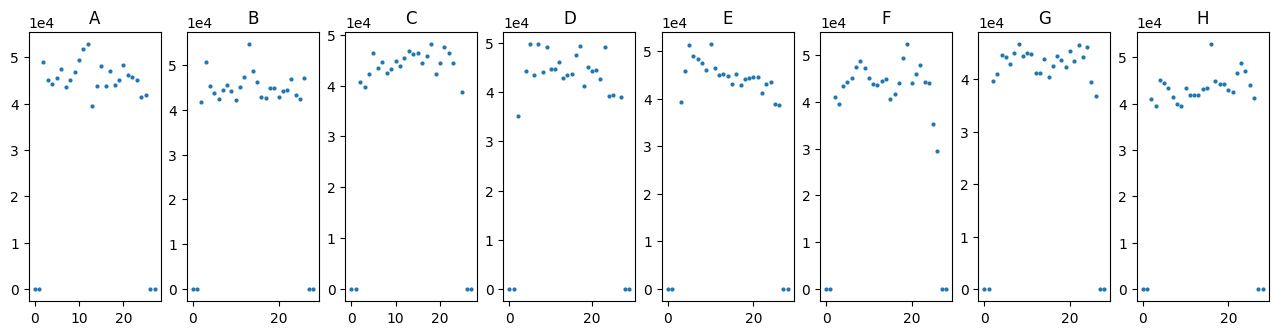

In [32]:
# 这里展示的是所有基因表达总和在各个角度的分布情况
# 有意思的这里的153度写成了-27度，原因跟条的顺序位置有关
# 该角度是从右上角往左下角切的
# 但是我们对于水平线上的投影都是从左到右排的，唯独153度这块出现问题
# 所以这里设置角度为-27，我认为也可以将153度这块的条顺序调转过来(已实践过，没有问题)

plt.figure(figsize=(16,3.5))
gs = plt.GridSpec(1,8)
for i, name_angle in enumerate(data_norm.keys()):
    ax = plt.subplot(gs[i])
    x = get_x(data_norm[name_angle])
    y = data_norm[name_angle].sum(0) #这里展示的是所有基因表达总和
#     c = np.array(["k","r", "b"])[get_plate(data_norm[name_angle])]
    ax.scatter(x,y, marker=".",lw=0,)
    ax.set_title("%s" % name_angle)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    
degrees_dict = {'A':-176,'B':180-18,'C':180-41,'D':180-63, 'E':180-81,"F":180-108,"G":180-131,"H":180-153}
angles_dict = {}
for k, v in degrees_dict.items():
    angles_dict[k] = np.deg2rad(v+180.)
angles = np.array( [angles_dict[i] for i in data_norm.keys()] )

widths_dict = {'A':4.15,'B':4.15,'C':4.22,'D':3.82, 'E':4,"F":4,"G":3.85,"H":4}
widths = np.array( [widths_dict[i] for i in data_norm.keys()] )# np.array([1,1,1,1,1])

In [33]:
D, projs_len = build_Design_Matrix(angles, widths, mask_img)
boundaries = np.r_[0,np.cumsum(projs_len)]
first_points = {'A':0,'B':0,'C':0,'D':0, 'E':0,"F":0,"G":0,"H":0}

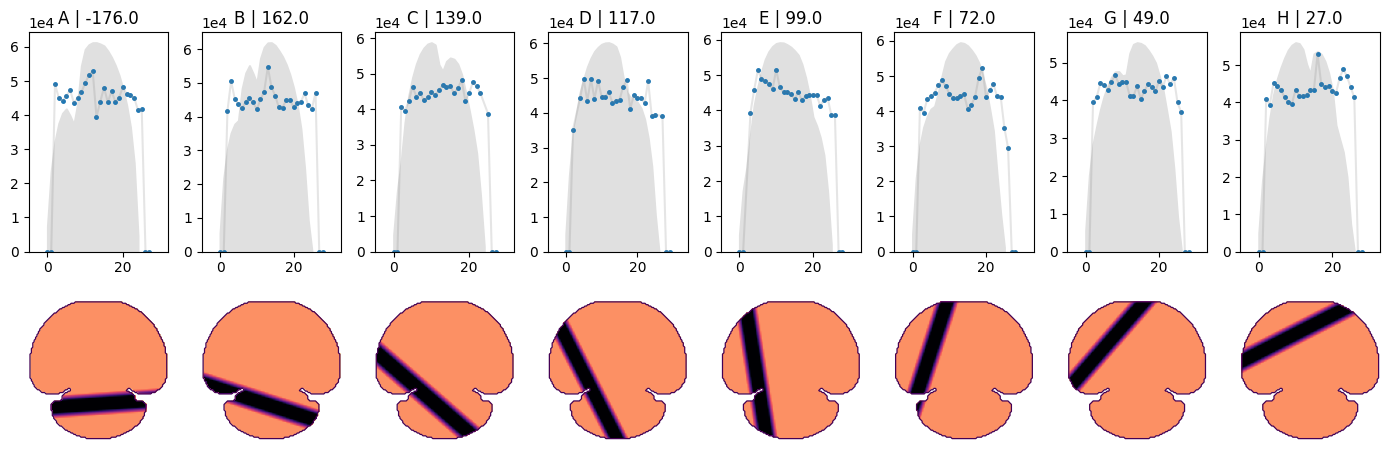

In [34]:
fig = plt.figure(figsize=(14,5.))
gs = plt.GridSpec(2,8)
import copy
palette = copy.copy(plt.cm.magma_r)
palette.set_under('w', alpha=0.0)

for i, (name_angle, df_angle) in enumerate(data_norm.items()):
    projected_total = D.dot(mask_img.flat[:])[boundaries[i]:boundaries[i+1]]
    ratio_factor = simps(df_angle.sum(0), get_x(df_angle)) / projected_total.sum() # 辛普森积分法
    x = get_x(df_angle)
    y = data_norm[name_angle].sum(0)
#     c = np.array(["k","r", "b"])[get_plate(data_norm[name_angle])]
    
    # Set the plot
    ax = plt.subplot(gs[0,i])
    # Plot points
    ax.scatter(x, y, marker=".", lw=0, s=50)
    ax.plot(x, y, alpha=0.2, c="gray")
    # Plot expected projection 
    #ax.plot(np.arange(projected_total.shape[0])+first_points[name_angle], projected_total*ratio_factor, c="k",lw=1.5,zorder=1000)
    ax.fill_between(np.arange(projected_total.shape[0])+first_points[name_angle], projected_total*ratio_factor, color="0.88",lw=1.5,zorder=-1)
    # Fix graphics
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_title("%s | %s" % (name_angle, angles[i]/(np.pi/180.)-180))
    ax.set_xlim(-5,get_x(df_angle)[-1]+5)
    ax.set_ylim(-0.2,)
    
    #Set the plot
    ax = plt.subplot(gs[1,i])
    s, e = boundaries[i],boundaries[i+1]
    a,b = np.array([5,8]) + s
    ax.imshow( (0.5*D[s:e].sum(0)+D[a:b,:].sum(0)).reshape(mask_img.shape[0], mask_img.shape[1]), cmap=palette, vmin=0.2 )
    ax.contour(mask_img, [0.5], linewidths=[0.9])
    plt.axis("off")
    # Plot first 3 slides
plt.tight_layout();
plt.savefig('./Overlap/5.pdf')

In [35]:
for angle in angles_dict.keys():
    data_norm[angle].loc["TOTAL",:] = data_norm[angle].loc[data_norm[angle].index != "TOTAL",:].sum(0) # written like this avoids problems if run twice

In [36]:
# widths_dict = {'A':4.15-0.6,'B':4.15-0.6,'C':4.22-0.5,'D':3.82-0.6, 'E':4-0.4,"F":4-0.5,"G":3.85-0.4,"H":4-0.5}
# widths = np.array( [widths_dict[i] for i in data_norm.keys()] )# np.array([1,1,1,1,1])

In [37]:
# widths_dict = {'A':4.15,'B':4.15,'C':4.22,'D':3.82, 'E':4,"F":4,"G":3.85,"H":4}
# widths = np.array( [widths_dict[i] for i in data_norm.keys()] )# np.array([1,1,1,1,1])

In [38]:
# +1 空
# widths_dict = {'A':4,'B':3.9,'C':4.1,'D':3.7, 'E':3.9,"F":3.9,"G":3.8,"H":3.9}
# widths = np.array( [widths_dict[i] for i in data_norm.keys()] )# np.array([1,1,1,1,1])

In [39]:
# +2 空
widths_dict = {'A':4-0.1,'B':3.9-0.1,'C':4.1-0.2,'D':3.7-0.2, 'E':3.9-0.15,"F":3.9-0.2,"G":3.8-0.1,"H":3.9-0.1}
widths = np.array( [widths_dict[i] for i in data_norm.keys()] )# np.array([1,1,1,1,1])

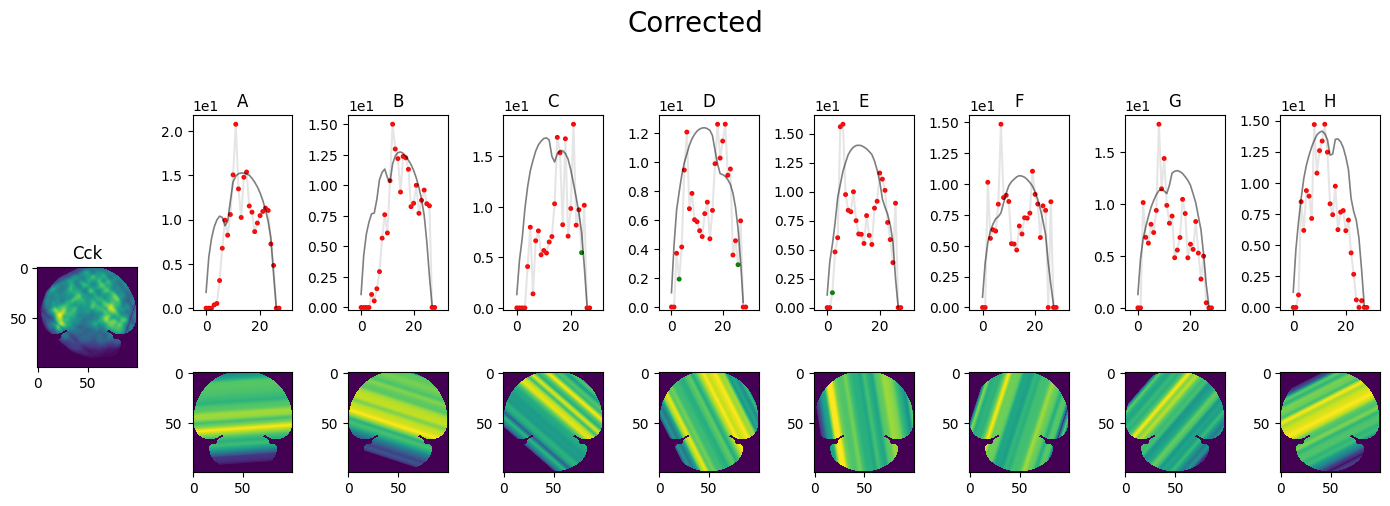

In [40]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("Cck", data_norm, np.array(list(angles_dict.values())), np.array(list(widths_dict.values())), first_points, mask_img)

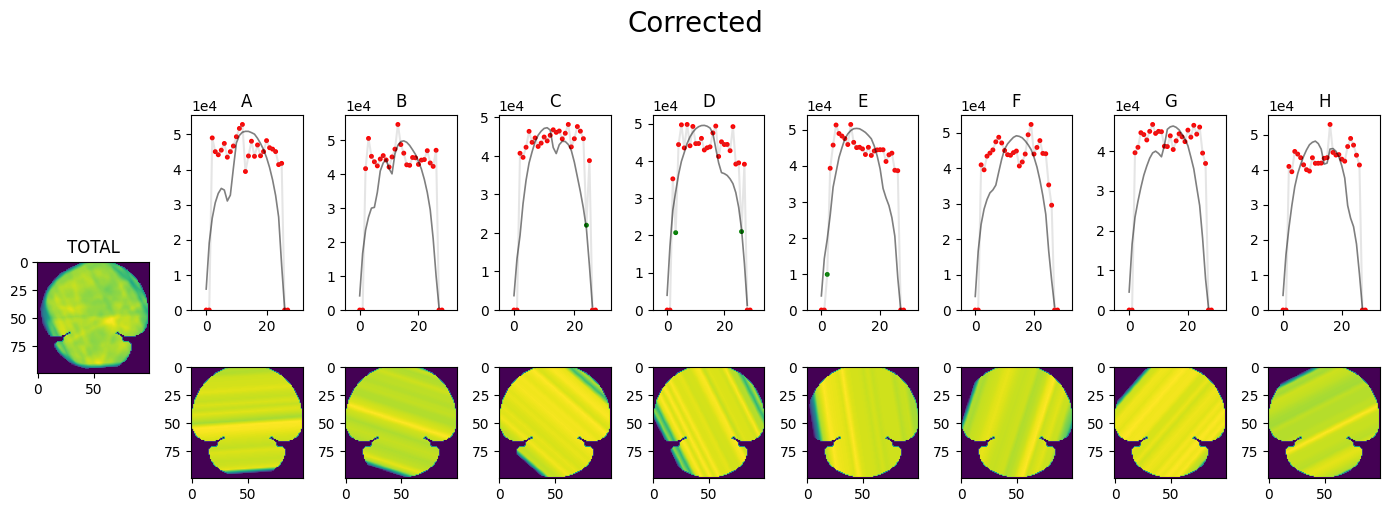

In [41]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("TOTAL", data_norm, np.array(list(angles_dict.values())), np.array(list(widths_dict.values())), first_points, mask_img)

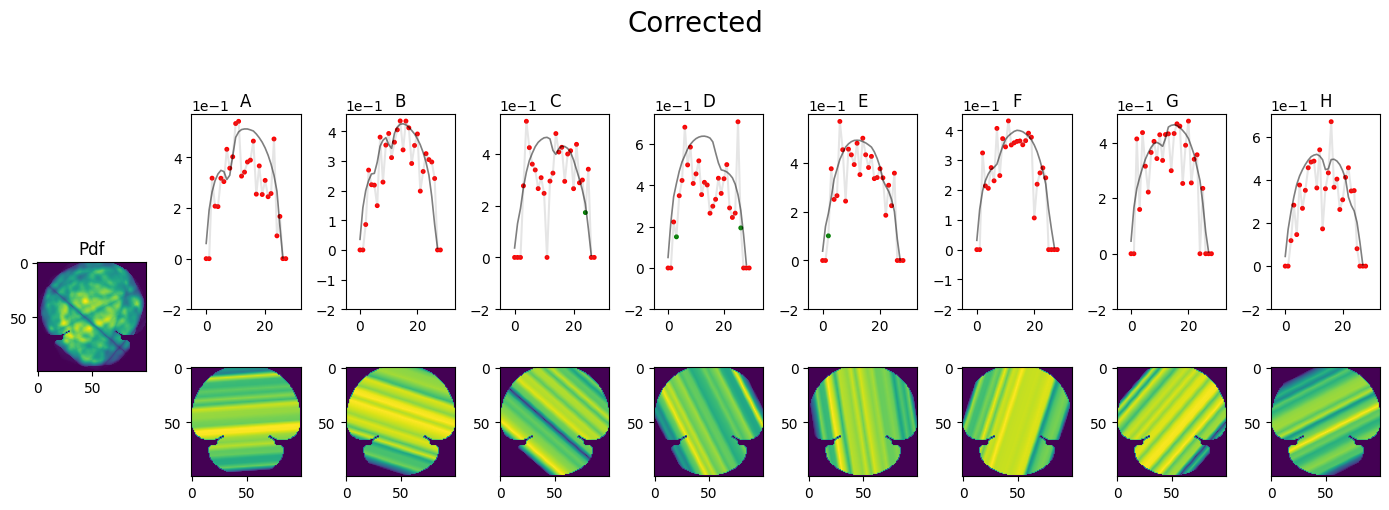

In [42]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("Pdf", data_norm, np.array(list(angles_dict.values())), np.array(list(widths_dict.values())), first_points, mask_img)

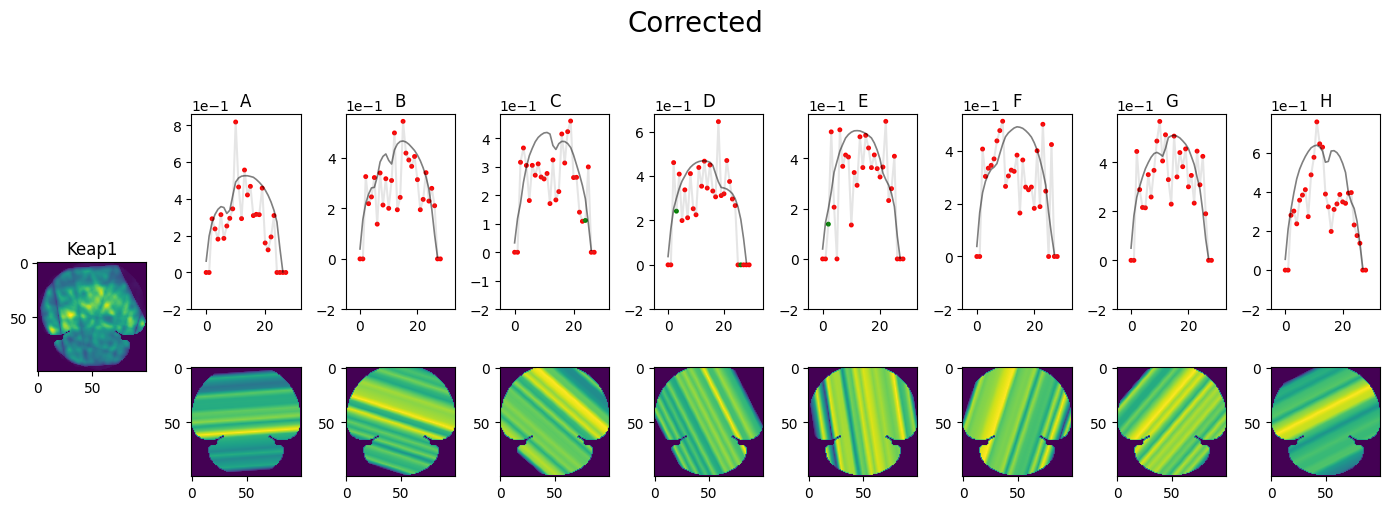

In [43]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("Keap1", data_norm, np.array(list(angles_dict.values())), np.array(list(widths_dict.values())), first_points, mask_img)

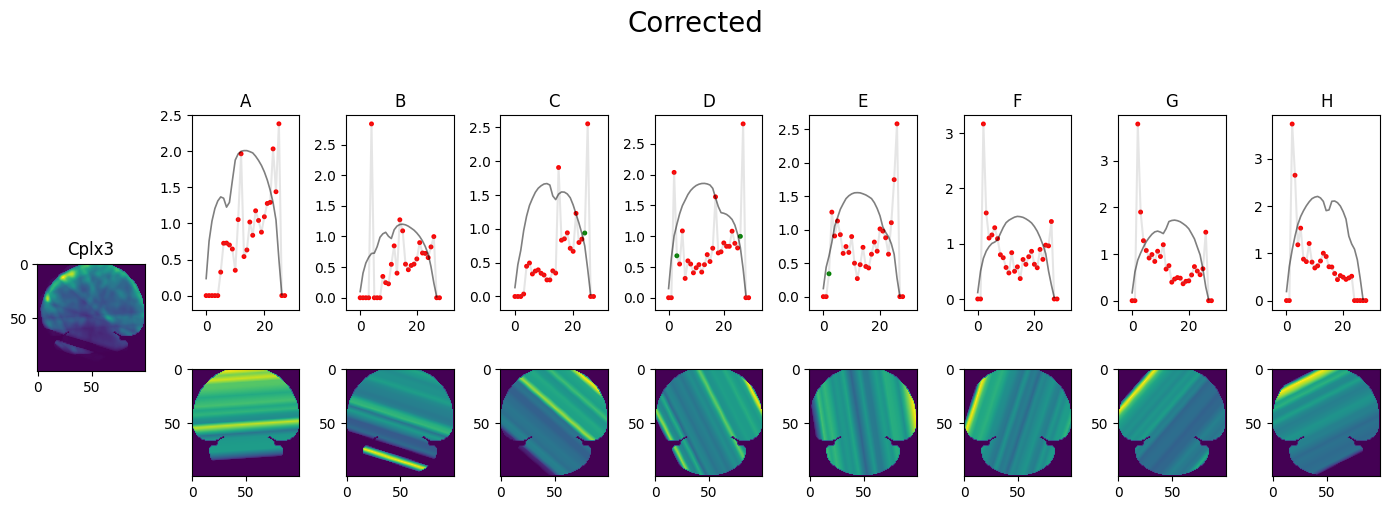

In [44]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("Cplx3", data_norm, np.array(list(angles_dict.values())), np.array(list(widths_dict.values())), first_points, mask_img)

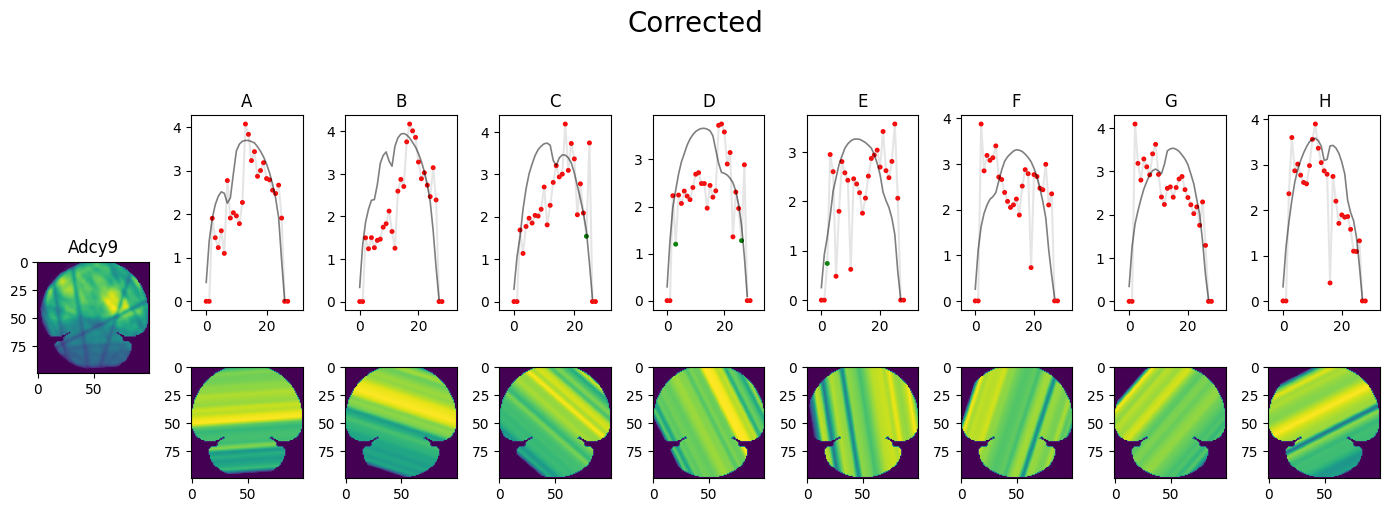

In [45]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("Adcy9", data_norm, np.array(list(angles_dict.values())), np.array(list(widths_dict.values())), first_points, mask_img)

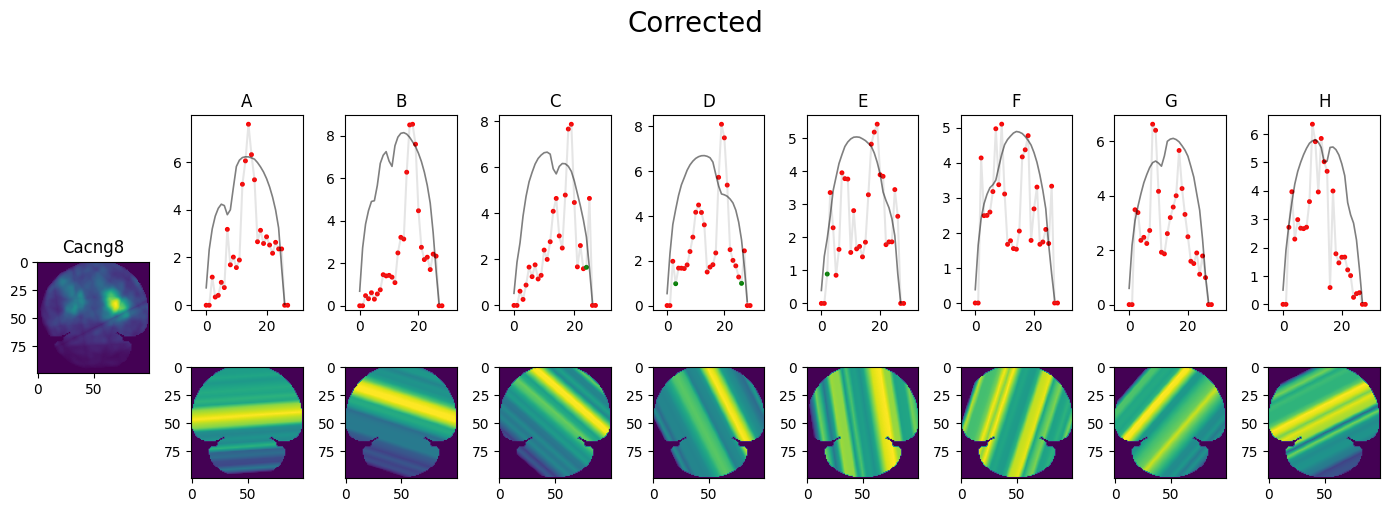

In [46]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("Cacng8", data_norm, np.array(list(angles_dict.values())), np.array(list(widths_dict.values())), first_points, mask_img)

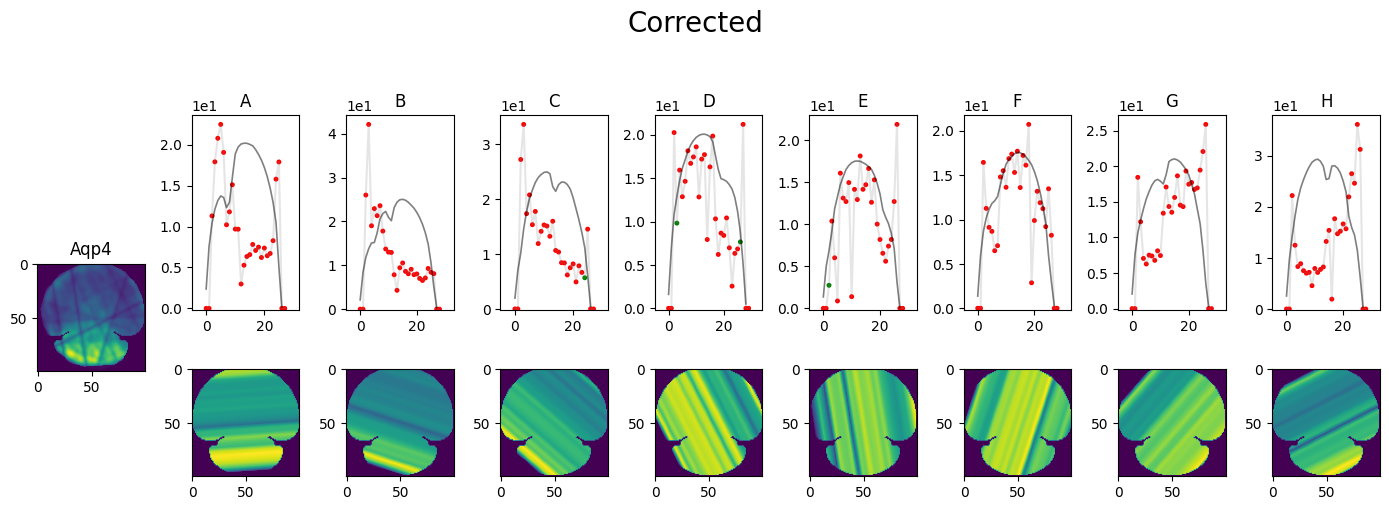

In [47]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("Aqp4", data_norm, np.array(list(angles_dict.values())), np.array(list(widths_dict.values())), first_points, mask_img)

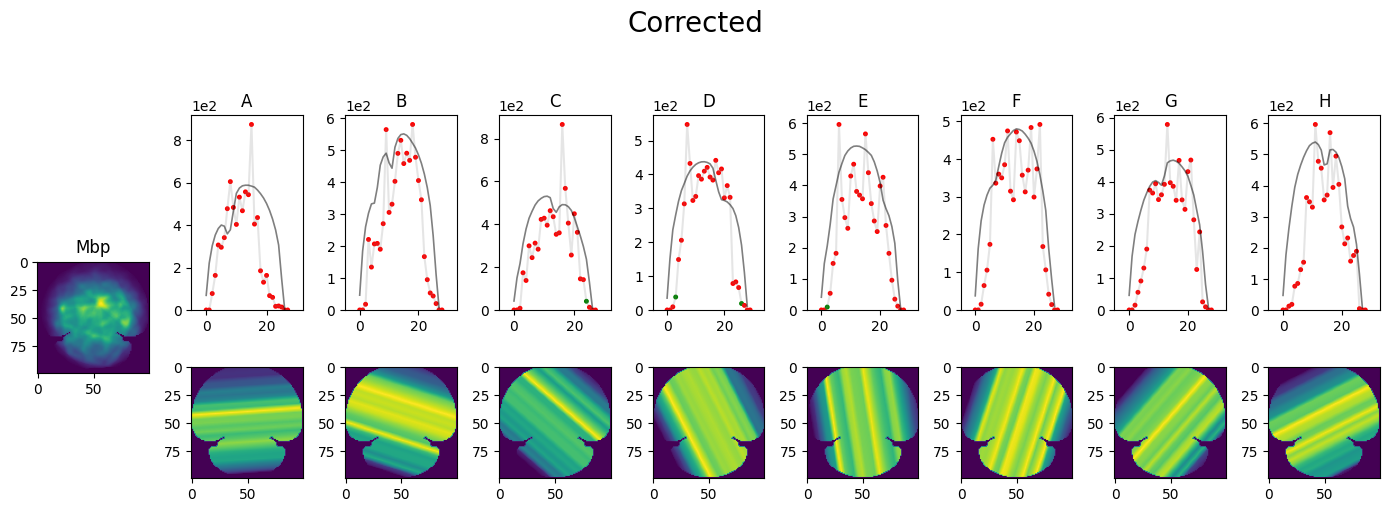

In [48]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("Mbp", data_norm, np.array(list(angles_dict.values())), np.array(list(widths_dict.values())), first_points, mask_img)

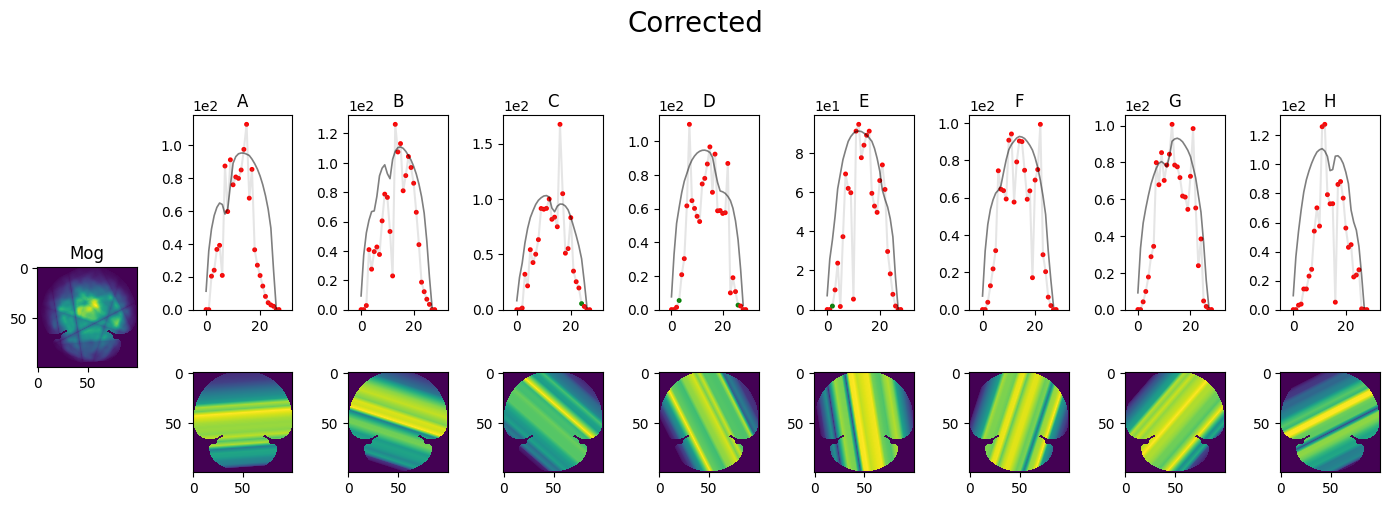

In [49]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("Mog", data_norm, np.array(list(angles_dict.values())), np.array(list(widths_dict.values())), first_points, mask_img)

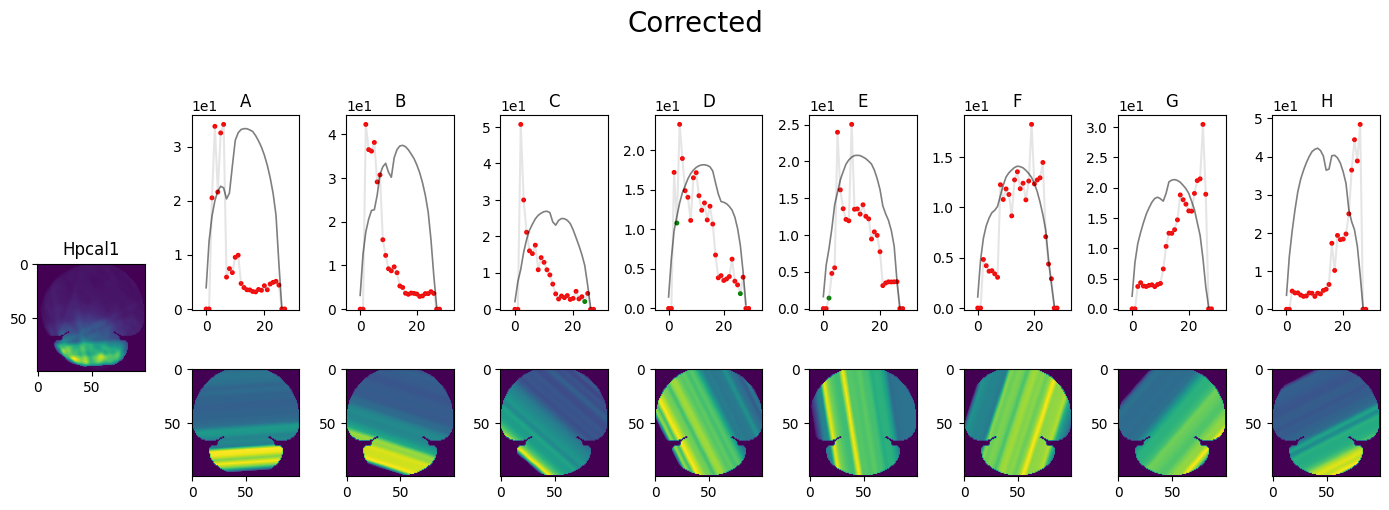

In [50]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("Hpcal1", data_norm, np.array(list(angles_dict.values())), np.array(list(widths_dict.values())), first_points, mask_img)
plt.savefig('./Overlap/6.pdf')

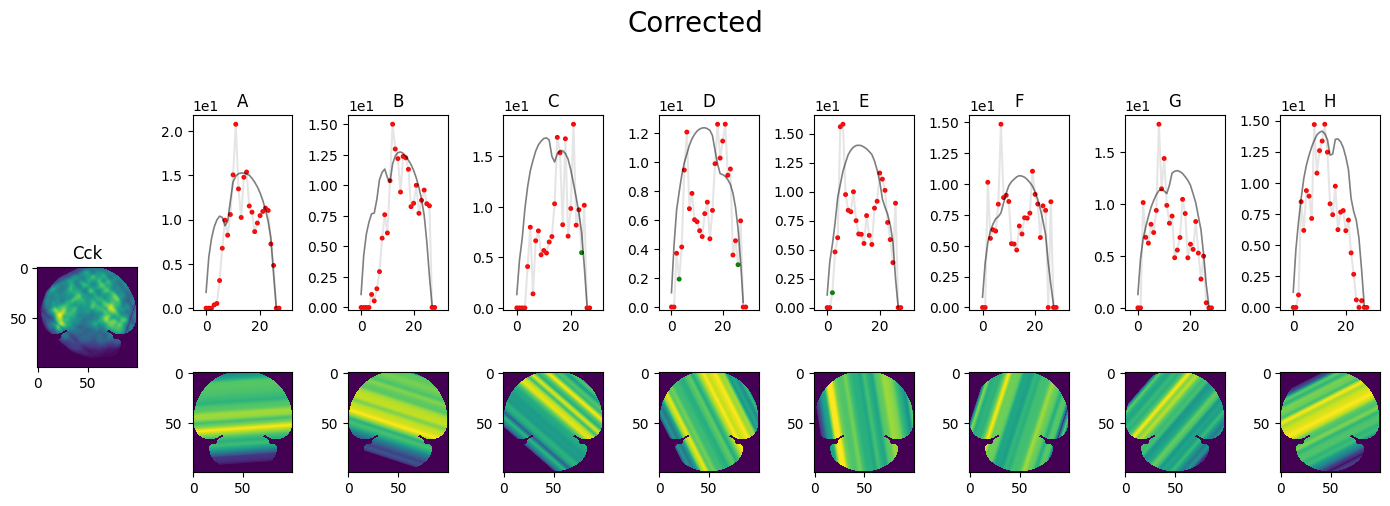

In [51]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("Cck", data_norm, np.array(list(angles_dict.values())), np.array(list(widths_dict.values())), first_points, mask_img)

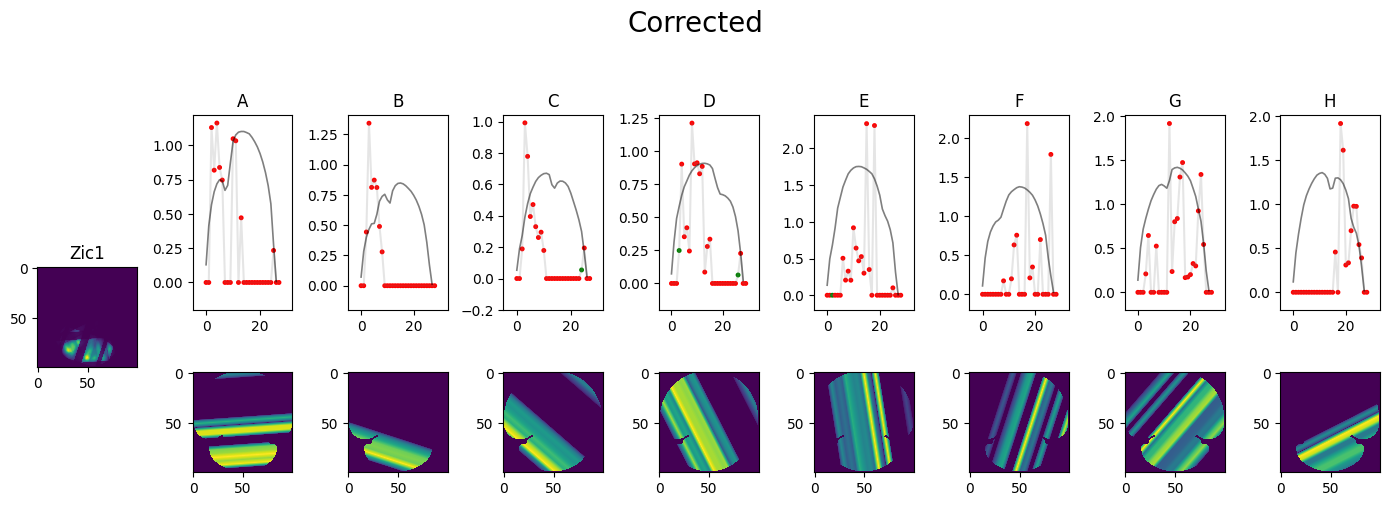

In [52]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("Zic1", data_norm, np.array(list(angles_dict.values())), np.array(list(widths_dict.values())), first_points, mask_img)

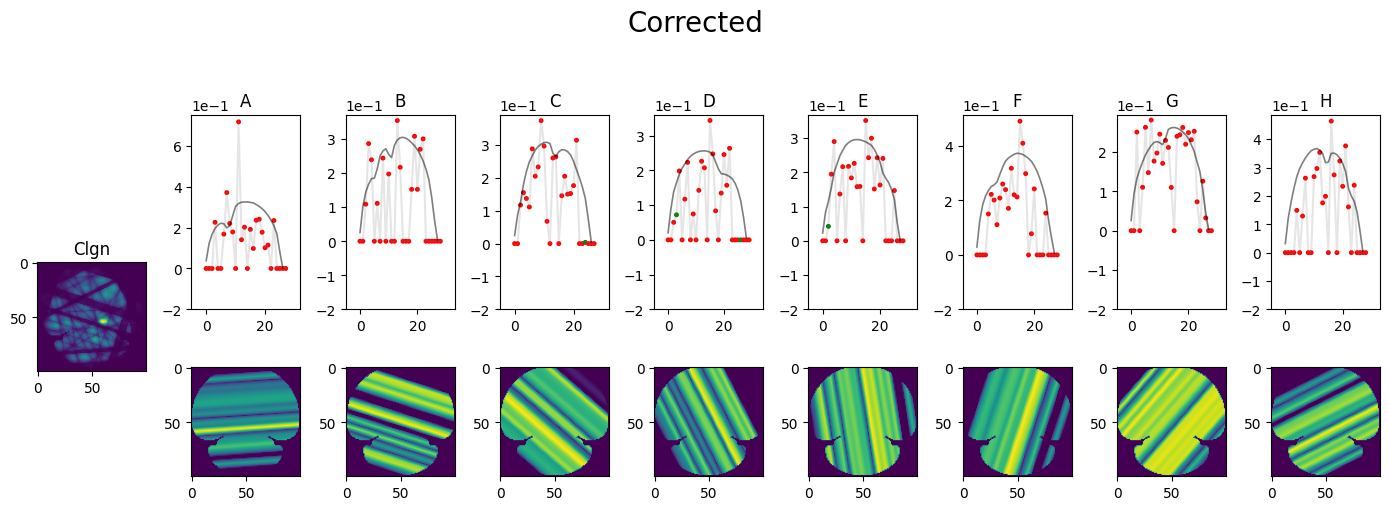

In [53]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("Clgn", data_norm, np.array(list(angles_dict.values())), np.array(list(widths_dict.values())), first_points, mask_img)

In [54]:
# creating configuration file
angles_names = list(data_norm.keys())
rec_conf = tomography.ReconstructionConfig(angles_names=angles_names,
                                     mask=mask_img,
                                     mask_thrs=0.2,
                                     reference_mask=mask_img,
                                     symmetry=True,
                                     masked_formulation=True,
                                     angles_values=np.array(list(angles_dict.values())),
                                     first_points=np.array(list(first_points.values())),
                                     widths=np.array(list(widths_dict.values())))

# creating dictionary of gene values
all_gene_values_dict = {gene:{name_angle:data_norm[name_angle].loc[gene,:].values for name_angle in data_norm.keys()} for gene in data_norm["A"].index}

In [55]:
import os
if os.path.exists("./Prepare_NN_Data/nonZero_Add_2_Config.hdf5"):
    os.remove("./Prepare_NN_Data/nonZero_Add_2_Config.hdf5")
if os.path.exists("./Prepare_NN_Data/nonZero_Add_2_Values.hdf5"):
    os.remove("./Prepare_NN_Data/nonZero_Add_2_Values.hdf5")

f = h5py.File('./Prepare_NN_Data/nonZero_Add_2_Values.hdf5', "w")
for i, (k, d) in enumerate(all_gene_values_dict.items()):
    for k2, v in d.items():
        f.create_dataset("/genes/%s/%s" % (k,k2), data=v)
for name_angle in data_norm.keys():
    f.create_dataset("coordinates/%s" % name_angle, data=get_x(data_norm[name_angle]) )
f.close()

#config file
rec_conf.to_file("./Prepare_NN_Data/nonZero_Add_2_Config.hdf5")

In [56]:
tg = tomography.Tomographer()
tg.load_cfg(rec_conf)
tg.connect_data('./Prepare_NN_Data/nonZero_Add_2_Values.hdf5')

 It might results in errors 
Filling with sorted(list(self.f["genes"].keys()))


### 准备神经网络

In [57]:
D, proj_len = build_Design_Matrix(np.array(list(angles_dict.values())),
                                  np.array(list(widths_dict.values())),
                                  mask_img,
                                  0.2,
                                  notation_inverse=True,
                                  return_projlen=True)

In [58]:
mask_bw = (mask_img > 0.2).astype(float)

In [59]:
def prepare_design_symmetry(D: np.ndarray) -> np.ndarray:
    """Add to the design matrix strip simmetric to the one in the input
    
    Args
    ----
    D: np.ndarray
        The design matrix as it comes from build_Design_Matrix

    Returns
    -------
    New design matrix with appended the simmetric angles

    """
    # Flip the mask assuming simmetry
    MD, ND = D.shape
    sqrtND = int(np.sqrt(ND))
    cols_ord = np.arange(ND).reshape(sqrtND, sqrtND)[:, ::-1].ravel()  # flipped index
    return np.append(D, D[:, cols_ord], 0)

def prepare_design_symmetry_masked(D: np.ndarray, mask_bw: np.ndarray) -> np.ndarray:
    """Design matrix using only the pixels in the mask and adding strips simmetric to the one in the input
    
    Args
    ----
    D: np.ndarray
        The design matrix as it comes from build_Design_Matrix
    mask_bw: np.ndarray (binary or boolean)
        The image used as mask. Entryes should be only 1/0 or True/False

    Returns
    -------
    New design matrix with appended the simmetric angles. And where only the pixels in the mask are considered

    """
    filt_mask = mask_bw.flat[:].astype(bool)  # prepare the mask to be used as a boolean filter
    return prepare_design_symmetry(D)[:, filt_mask]

In [60]:
A = prepare_design_symmetry_masked(D, mask_bw)

In [61]:
from typing import List
def prepare_observations(projections: List[np.ndarray], xs: List[np.ndarray],
                         first_points: List[int], projs_len: List[int],
                         interpolation: str="linear", verbose: bool=False) -> np.ndarray:
    """Prepare the observation vector `b`
    
    Args
    ----------
    projections: list of 1-D array
        a list of projection. Projections are first selected so that the first value is the first reliable section and
        the last the last reliable section
    xs: list of 1-D array
        Contains arrays indicating wich are indexes of the 'projections' input.
        `projections` are usually filtered and trimmed, so an ix array is kept to keep track of it. 
        Its values[i] usually gets filtered and some samples are missing.
        e.g. [ array([20,21,22,24,25,27,30,...]), array([10,11,12,15,16,17,18,...]), array([3,4,7,9,10,11,12,...]) ]
    first_points: list of int
        for every proj-angle it indicates how shifted it is from the theoretical one
    projs_len: list of int
        the expected number of slices that should be taken in account starting from `list_of_points[i]`
    interpolation: str
        kind interpolation one of "linear", "cubic", "mixed"
    verbose: bool
        prints min(xi), max(xi), max(xi)-min(xi)+1, n_points, len(xi), len(p)

    Returns
    -------
    final_proj: 1-D array
        The projections ready to be given as an imput of a regression problem
    """

    final_proj = np.array([])
    for projection, xi, first_point, n_points in zip(projections, xs, first_points, projs_len):
        full_x = np.arange(first_point, first_point + n_points)
        p = projection.copy()
        
        # take the points between first point and last point
        bool_ix = (first_point <= xi) & (xi < first_point + n_points)
        xi = xi[bool_ix]
        p = p[bool_ix]

        # Deal with some special cases if they occur (e.g. samples at the extremities did not wokr)
        if first_point not in xi:
            xi = np.r_[first_point, xi]
            p = np.r_[0, p]
        if (first_point + n_points - 1) not in xi:
            xi = np.r_[xi, first_point + n_points - 1]
            p = np.r_[p, 0]
            
        if verbose:
            print(np.min(xi), np.max(xi), np.max(xi) - np.min(xi) + 1, n_points, len(xi), len(p))
        
        # Perform the interpolation for the missing ixs
        if interpolation == "linear":
            f1 = interp1d(xi, p, kind='linear', fill_value=0, bounds_error=False)
            interpolated = f1(full_x)
        elif interpolation == "cubic":
            f3 = interp1d(xi, p, kind='cubic', fill_value=0, bounds_error=False)
            interpolated = np.clip(f3(full_x), a_min=0, a_max=1.2 * max(p))
        elif interpolation == "mixed":
            f1 = interp1d(xi, p, kind='linear', fill_value=0, bounds_error=False)
            f3 = interp1d(xi, p, kind='cubic', fill_value=0, bounds_error=False)
            intp1 = np.clip(f1(full_x), a_min=0, a_max=1.2 * max(p))
            intp3 = np.clip(f3(full_x), a_min=0, a_max=1.2 * max(p))
            intp0 = intp1 * np.array([(i in xi) for i in full_x])
            interpolated = 0.15 * intp3 + 0.35 * intp1 + 0.5 * intp0

        final_proj = np.r_[final_proj, interpolated]  # This is just appending to the previous projections
    return final_proj


def prepare_observations_symmetry(projections: List[np.ndarray], xs: List[np.ndarray],
                                  first_points: List[int], projs_len: List[int],
                                  interpolation: str="linear", verbose: bool=False) -> np.ndarray:
    """Prepare the observation vector `b` assuming symmetry.
    It will will copy the observations at one angle so to assume that the projection at the symmetrical is the same
    
    Args
    ----------
    projections: list of 1-D array
        a list of projection. Projections are first selected so that the first value is the first reliable section and
        the last the last reliable section
    xs: list of 1-D array
        Contains arrays indicating wich are indexes of the 'projections' input.
        `projections` are usually filtered and trimmed, so an ix array is kept to keep track of it.
        Its values[i] usually gets filtered and some samples are missing.
        e.g. [ array([20,21,22,24,25,27,30,...]), array([10,11,12,15,16,17,18,...]), array([3,4,7,9,10,11,12,...]) ]
    first_points: list of int
        for every proj-angle it indicates how shifted it is from the theoretical one
    projs_len: list of int
        the expected number of slices that should be taken in account starting from `list_of_points[i]`
    interpolation: str
        kind interpolation one of "linear", "cubic", "mixed"
    verbose: bool
        prints min(xi), max(xi), max(xi)-min(xi)+1, n_points, len(xi), len(p)

    Returns
    -------
    final_proj: 1-D array
        The projections ready to be given as an imput of a regression problem
    """

    final_proj = prepare_observations(projections, xs, first_points, projs_len, interpolation, verbose)
    final_proj = np.r_[final_proj, final_proj]
    return final_proj

In [62]:
data = h5py.File("./Prepare_NN_Data/nonZero_Add_2_Values.hdf5", "r")

In [63]:
data_xs = []
for angle in angles_names:
    data_xs.append(data["coordinates/%s" % angle][:])

In [64]:
gene_list = []
for gene in data_norm["A"].index:
    gene_expression = [data["genes/%s/%s" % (gene, angle)][:] for angle in angles_names]
    b = prepare_observations_symmetry(projections=gene_expression, xs=data_xs,
                         first_points=np.array(list(first_points.values())), projs_len=proj_len,
                         interpolation="linear")
    gene_list.append(b)

In [65]:
angle_space = np.vstack(gene_list)

In [66]:
angle_space_pd = pd.DataFrame(angle_space)
angle_space_pd.index = data_norm["A"].index

In [67]:
np.save("./Prepare_NN_Data/A_SP_Add_2.npy",A)
np.save("./Prepare_NN_Data/angle_space_SP_Add_2.npy",angle_space)

In [68]:
np.where(angle_space_pd.index == "Hpcal1")

(array([2248]),)

In [69]:
angle_space_pd.to_csv("./Prepare_NN_Data/angle_space_SP_Add_2.csv")

### tomographer重构

In [70]:
gene_name = "Cacng8"
result1 = tg.reconstruct(gene_name, alpha_beta='auto', crossval_kwargs={'domain': [(0,4), (0.05,6)],
                                                                                       'logged_grid':False,
                                                                                       'extra_evals': 5,
                                                                                       'initial_grid_n': 4},nb_r=1.2) # crossval_kwargs={"domain":[(-5, 0.8), (-6, 2.5)]} # alpha_beta=(1,0.01)


[27, 28, 27, 29, 28, 28, 28, 28]
(223, 10000)
mask_bw (100, 100)
(446, 7330)
[(28,), (29,), (27,), (28,), (28,), (29,), (29,), (29,)]
(446,)
hhhh1
hhhh3


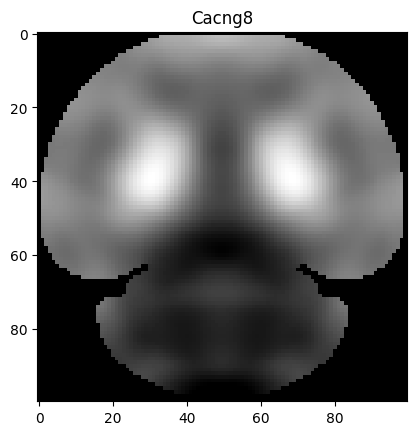

In [71]:
plt.imshow(result1,cmap="gray")
plt.title(gene_name)
plt.show()

In [82]:
gene_name = "Aqp4"
result2 = tg.reconstruct(gene_name, alpha_beta='auto', crossval_kwargs={'domain': [(0,4), (0.05,6)],
                                                                                       'logged_grid':False,
                                                                                       'extra_evals': 5,
                                                                                       'initial_grid_n': 4},nb_r=1.2) # crossval_kwargs={"domain":[(-5, 0.8), (-6, 2.5)]} # alpha_beta=(1,0.01)


[(28,), (29,), (27,), (28,), (28,), (29,), (29,), (29,)]
(446,)
hhhh1
hhhh3


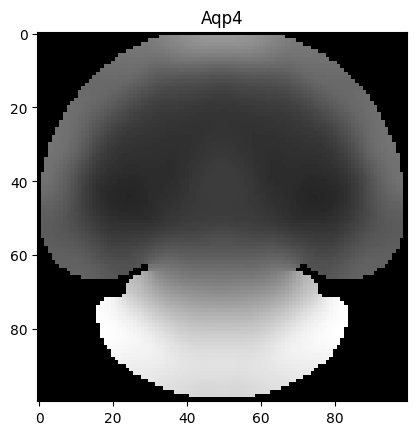

In [83]:
# 加了空边,细调了宽度
plt.imshow(result2,cmap="gray")
plt.title(gene_name)
plt.show()

In [84]:
gene_name = "Scg2"
result3 = tg.reconstruct(gene_name, alpha_beta='auto', crossval_kwargs={'domain': [(0,4), (0.05,6)],
                                                                                       'logged_grid':False,
                                                                                       'extra_evals': 5,
                                                                                       'initial_grid_n': 4},nb_r=1.2) # crossval_kwargs={"domain":[(-5, 0.8), (-6, 2.5)]} # alpha_beta=(1,0.01)


[(28,), (29,), (27,), (28,), (28,), (29,), (29,), (29,)]
(446,)
hhhh1
hhhh3


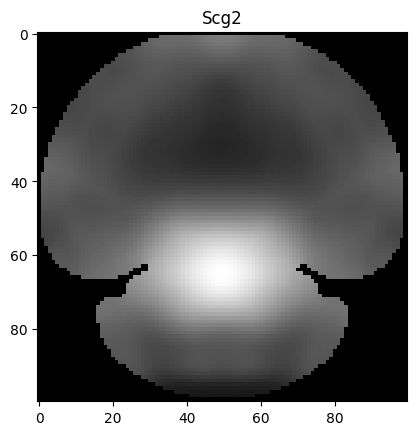

In [85]:
# 加了空边,细调了宽度
plt.imshow(result3,cmap="gray")
plt.title(gene_name)
plt.show()

In [86]:
gene_name = "Cplx3"
result4 = tg.reconstruct(gene_name, alpha_beta='auto', crossval_kwargs={'domain': [(0,4), (0.05,6)],
                                                                                       'logged_grid':False,
                                                                                       'extra_evals': 5,
                                                                                       'initial_grid_n': 4},nb_r=1.2) # crossval_kwargs={"domain":[(-5, 0.8), (-6, 2.5)]} # alpha_beta=(1,0.01)


[(28,), (29,), (27,), (28,), (28,), (29,), (29,), (29,)]
(446,)
hhhh1
hhhh3


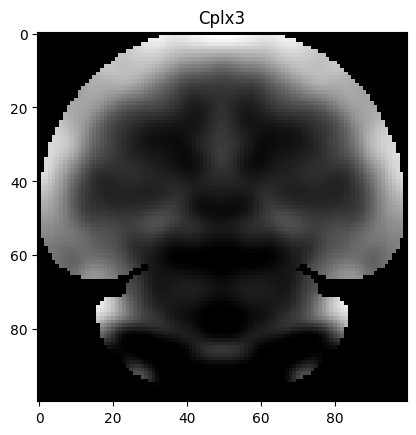

In [87]:
# 加了空边不调宽度
plt.imshow(result4,cmap="gray")
plt.title(gene_name)
plt.show()

In [88]:
gene_name = "Hpcal1"
result5 = tg.reconstruct(gene_name, alpha_beta='auto', crossval_kwargs={'domain': [(0,4), (0.05,6)],
                                                                                       'logged_grid':False,
                                                                                       'extra_evals': 5,
                                                                                       'initial_grid_n': 4},nb_r=1.2) # crossval_kwargs={"domain":[(-5, 0.8), (-6, 2.5)]} # alpha_beta=(1,0.01)


[(28,), (29,), (27,), (28,), (28,), (29,), (29,), (29,)]
(446,)
hhhh1
hhhh3


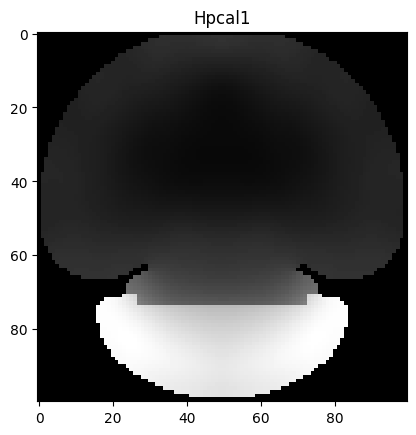

In [89]:
# 加了空边,细调了宽度
plt.imshow(result5,cmap="gray")
plt.title(gene_name)
plt.show()

In [74]:
gene_name = "Cck"
result1 = tg.reconstruct(gene_name, alpha_beta='auto', crossval_kwargs={'domain': [(0,4), (0.05,6)],
                                                                                       'logged_grid':False,
                                                                                       'extra_evals': 5,
                                                                                       'initial_grid_n': 4},nb_r=1.2) # crossval_kwargs={"domain":[(-5, 0.8), (-6, 2.5)]} # alpha_beta=(1,0.01)


[(28,), (29,), (27,), (28,), (28,), (29,), (29,), (29,)]
(446,)
hhhh1
hhhh3


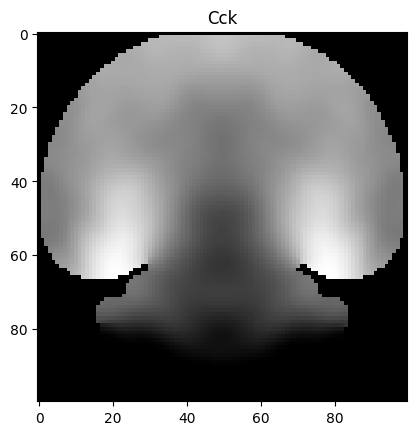

In [75]:
plt.imshow(result1,cmap="gray")
plt.title(gene_name)
plt.show()

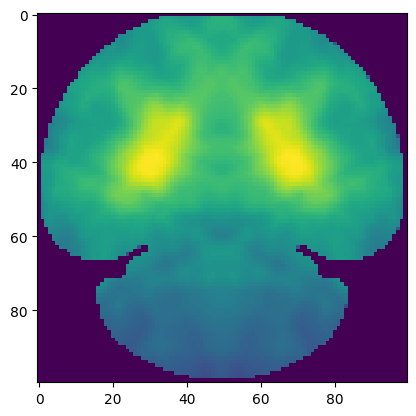

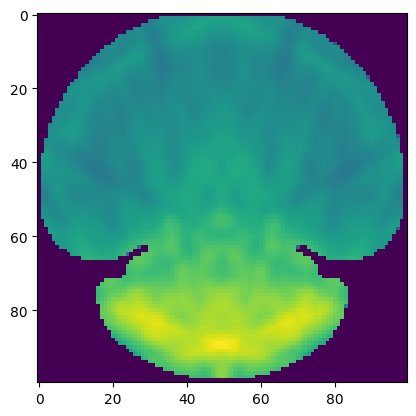

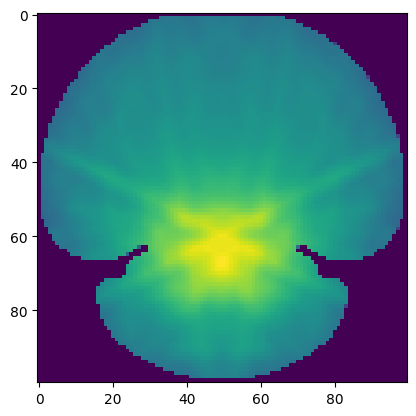

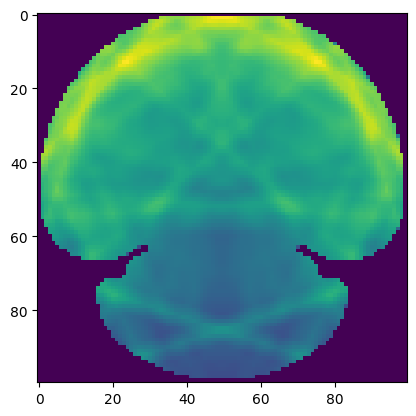

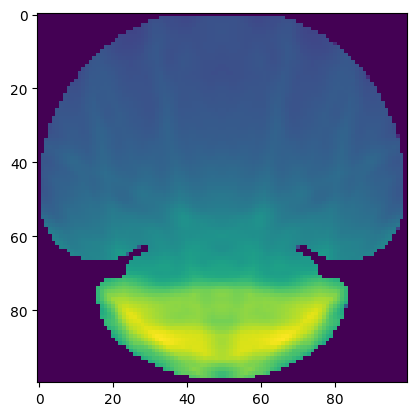

In [90]:
def place_inside_mask(values: np.ndarray, mask_bw: np.ndarray) -> np.ndarray:
    """Place the values at the position that are 1/True in mask followin the C_CONTIGUOUS enumeration order

    Args
    ----
    values: np.ndarray (1d, float)
        the vaues to fill in mask
    mask_bw: np.ndarray (2d, binary or boolean)
        the mask to fill values in
    Returns
    -------
    x: np.ndarray 2d
        2d array with the values subsittuted in the right place of the mask
    """
    # assert np.allclose(mask.sum(), len(values))
    x = np.zeros(mask_bw.shape)
    x.flat[mask_bw.flat[:].astype(bool)] = values
    return x

plt.imshow(place_inside_mask(result1.flat[:][mask_bw.flat[:].astype(bool)],mask_bw))
plt.imshow(place_inside_mask(np.dot(angle_space_pd.loc["Cacng8",:],A),mask_bw))
plt.show()

plt.imshow(place_inside_mask(result2.flat[:][mask_bw.flat[:].astype(bool)],mask_bw))
plt.imshow(place_inside_mask(np.dot(angle_space_pd.loc["Aqp4",:],A),mask_bw))
plt.show()

plt.imshow(place_inside_mask(result3.flat[:][mask_bw.flat[:].astype(bool)],mask_bw))
plt.imshow(place_inside_mask(np.dot(angle_space_pd.loc["Scg2",:],A),mask_bw))
plt.show()

plt.imshow(place_inside_mask(result4.flat[:][mask_bw.flat[:].astype(bool)],mask_bw))
plt.imshow(place_inside_mask(np.dot(angle_space_pd.loc["Cplx3",:],A),mask_bw))
plt.show()

plt.imshow(place_inside_mask(result5.flat[:][mask_bw.flat[:].astype(bool)],mask_bw))
plt.imshow(place_inside_mask(np.dot(angle_space_pd.loc["Hpcal1",:],A),mask_bw))
plt.show()